In [363]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    StratifiedKFold,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
    classification_report,
)
from joblib import parallel_backend
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

label_mapping = {'STARFORMING': 0, 'STARBURST': 1}

galaxy_data = pd.read_csv("clean_data.csv")
galaxy_data['subclass'] = galaxy_data['subclass'].map(label_mapping)
galaxy_data = galaxy_data.head(10000)

all_inputs = galaxy_data.drop(columns=["subclass"]).values

galaxy_data_normalized = pd.read_csv("clean_data_normalized.csv")
galaxy_data_normalized = galaxy_data_normalized.head(10000)
galaxy_data_normalized['subclass'] = galaxy_data_normalized['subclass'].map(label_mapping)
all_inputs_normalized = galaxy_data_normalized.drop(columns=["subclass"]).values

all_labels = galaxy_data["subclass"].values
nr_features = all_inputs.shape[1]

In [364]:
(training_inputs, testing_inputs, training_classes, testing_classes) = train_test_split(
    all_inputs, all_labels, test_size=0.25
)

In [365]:
(
    training_inputs_normalized,
    testing_inputs_normalized,
    training_classes_normalized,
    testing_classes_normalized,
) = train_test_split(all_inputs_normalized, all_labels, test_size=0.25)

In [366]:
under_sampler = RandomUnderSampler()
inputs_under_sampl, labels_under_sampl = under_sampler.fit_resample(
    all_inputs, all_labels
)
inputs_under_sampl_normalized, labels_under_sampl_normalized = (
    under_sampler.fit_resample(all_inputs_normalized, all_labels)
)

len(inputs_under_sampl[labels_under_sampl == 1]), len(
    inputs_under_sampl[labels_under_sampl == 0]
)

(2548, 2548)

In [367]:
over_sampler = RandomOverSampler()
inputs_over_sampl, labels_over_sampl = over_sampler.fit_resample(all_inputs, all_labels)
inputs_over_sampl_normalized, labels_over_sampl_normalized = over_sampler.fit_resample(
    all_inputs_normalized, all_labels
)

len(inputs_over_sampl[labels_over_sampl == 1]), len(
    inputs_over_sampl[labels_over_sampl == 0]
)

(7452, 7452)

In [368]:
def test_classifier(
    clf,
    data,
    labels,
    parameter_grid,
    cv=StratifiedKFold(n_splits=2),
    return_metrics=None,
    optimize_metric=True,
    return_train_score=False,
):
    grid_search = GridSearchCV(
        clf,
        parameter_grid,
        cv=cv,
        n_jobs=-1,
        verbose=1,
        scoring=return_metrics,
        refit=optimize_metric,
        return_train_score=return_train_score,
    )
    with parallel_backend("loky"):
        grid_search.fit(data, labels)
    print("Best score: {}".format(grid_search.best_score_))
    print("Best parameters: {}".format(grid_search.best_params_))

    return grid_search

In [369]:
def get_max_value(param1, param2, value1, value2, parameter_idx, current_list) -> float:
    """Auxiliar function to plot_grid_search"""
    if parameter_idx == param1:
        return get_max_value(
            param1, param2, value1, value2, parameter_idx + 1, current_list[value1]
        )
    if parameter_idx == param2:
        return get_max_value(
            param1, param2, value1, value2, parameter_idx + 1, current_list[value2]
        )

    if type(current_list) is np.float64:
        return current_list

    max_value = 0
    for value in current_list:
        max_value = max(
            max_value,
            get_max_value(param1, param2, value1, value2, parameter_idx + 1, value),
        )
    return max_value


def plot_grid_search(
    grid_search, results_metric, parameter_grid, parameter_names, filename
):
    shape = [len(parameter_grid[parameter]) for parameter in parameter_names]
    print("Best score: {}".format(grid_search.best_score_))
    print("Best parameters: {}".format(grid_search.best_params_))

    results = grid_search.cv_results_
    ndimensional_result_matrix = np.zeros(tuple(shape))

    for param, score in zip(results["params"], results[results_metric]):
        indices = [
            parameter_grid[param_name].index(param[param_name])
            for param_name in parameter_names
        ]
        ndimensional_result_matrix[tuple(indices)] = score

    fig, axes = plt.subplots(
        len(parameter_names) - 1, len(parameter_names) - 1, figsize=(30, 30)
    )
    for param1_idx in range(len(parameter_names)):
        # Complexity: O(len(parameter_grid) ^ 2 * Mult(len(param_values) for param_values in parameter_grid.values())
        # Acceptable complexity
        for param2_idx in range(param1_idx + 1, len(parameter_names)):
            if param1_idx == param2_idx:
                continue
            matrix = [
                [
                    get_max_value(
                        param1_idx,
                        param2_idx,
                        value1,
                        value2,
                        0,
                        ndimensional_result_matrix,
                    )
                    for value2 in range(shape[param2_idx])
                ]
                for value1 in range(shape[param1_idx])
            ]

            ax1 = param1_idx
            ax2 = param2_idx - 1
            # ax1 = param1_idx
            # ax2 = param2_idx
            sb.heatmap(matrix, cmap="Blues", annot=True, ax=axes[ax1, ax2])
            axes[ax1, ax2].set_yticks(
                np.arange(shape[param1_idx]) + 0.5,
                grid_search.param_grid[parameter_names[param1_idx]],
            )
            axes[ax1, ax2].set_ylabel(parameter_names[param1_idx])

            axes[ax1, ax2].set_xticks(
                np.arange(shape[param2_idx]) + 0.5,
                grid_search.param_grid[parameter_names[param2_idx]],
            )
            axes[ax1, ax2].set_xlabel(parameter_names[param2_idx])
    plt.savefig(filename)


def plot_measures(
    parameter: str,
    parameter_label: str,
    parameter_values: list,
    gridcv_results: dict,
    score_measures: list[str],
    filename: str,
):
    result = {measure: [0 for _ in parameter_values] for measure in score_measures}

    params = gridcv_results["params"]
    for measure in score_measures:
        scores = gridcv_results[measure]
        for i, p in enumerate(params):
            value_index = parameter_values.index(p[parameter])
            result[measure][value_index] = max(result[measure][value_index], scores[i])

    plt.figure(figsize=(15, 10))
    for measure in score_measures:
        plt.plot(parameter_values, result[measure], label=measure)

    plt.xlabel(parameter_label)
    plt.ylabel("Metric Value")
    plt.title(f"Metrics evolution with {parameter_label}")
    plt.legend()
    plt.xticks(parameter_values)

    plt.savefig(filename)


def print_classification_report(
    model, testing_inputs, testing_classes, show_feature_importances=True
):
    # plot histogarm with feature importance
    if show_feature_importances:
        plt.bar(
            galaxy_data.drop(columns=["subclass"]).columns, model.feature_importances_
        )
        plt.xticks(rotation=90)

    predictions = model.predict(testing_inputs)
    print(classification_report(testing_classes, predictions))

    cf_matrix = confusion_matrix(testing_classes, model.predict(testing_inputs))
    cm = ConfusionMatrixDisplay(cf_matrix, display_labels=model.classes_)
    cm.plot()
    plt.show()
    metrics = {
        "accuracy": accuracy_score(testing_classes, predictions),
        "precision": precision_score(testing_classes, predictions),
        "recall" : recall_score(testing_classes, predictions),
        "f1": f1_score(testing_classes, predictions),
    }
    return metrics

## Decision Tree

In [370]:
decision_tree_classifier = DecisionTreeClassifier()

max_depth = 20
max_features = nr_features
features_step = 4
nr_tested_features = (max_features + 1) // features_step

parameter_grid_dt = {
    "max_depth": list(range(1, max_depth + 1)),
    "max_features": list(range(1, max_features + features_step, features_step)),
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
}
print(parameter_grid_dt)

dt_metrics = ["accuracy", "f1", "precision", "recall"]
grid_search_dt = test_classifier(
    decision_tree_classifier,
    all_inputs,
    all_labels,
    parameter_grid_dt,
    return_train_score=True,
    return_metrics=dt_metrics,
    optimize_metric="f1",
)

{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'max_features': [1, 5, 9, 13, 17, 21, 25], 'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random']}
Fitting 2 folds for each of 840 candidates, totalling 1680 fits
Best score: 0.6971737636374045
Best parameters: {'criterion': 'log_loss', 'max_depth': 7, 'max_features': 21, 'splitter': 'best'}


Best score: 0.6971737636374045
Best parameters: {'criterion': 'log_loss', 'max_depth': 7, 'max_features': 21, 'splitter': 'best'}


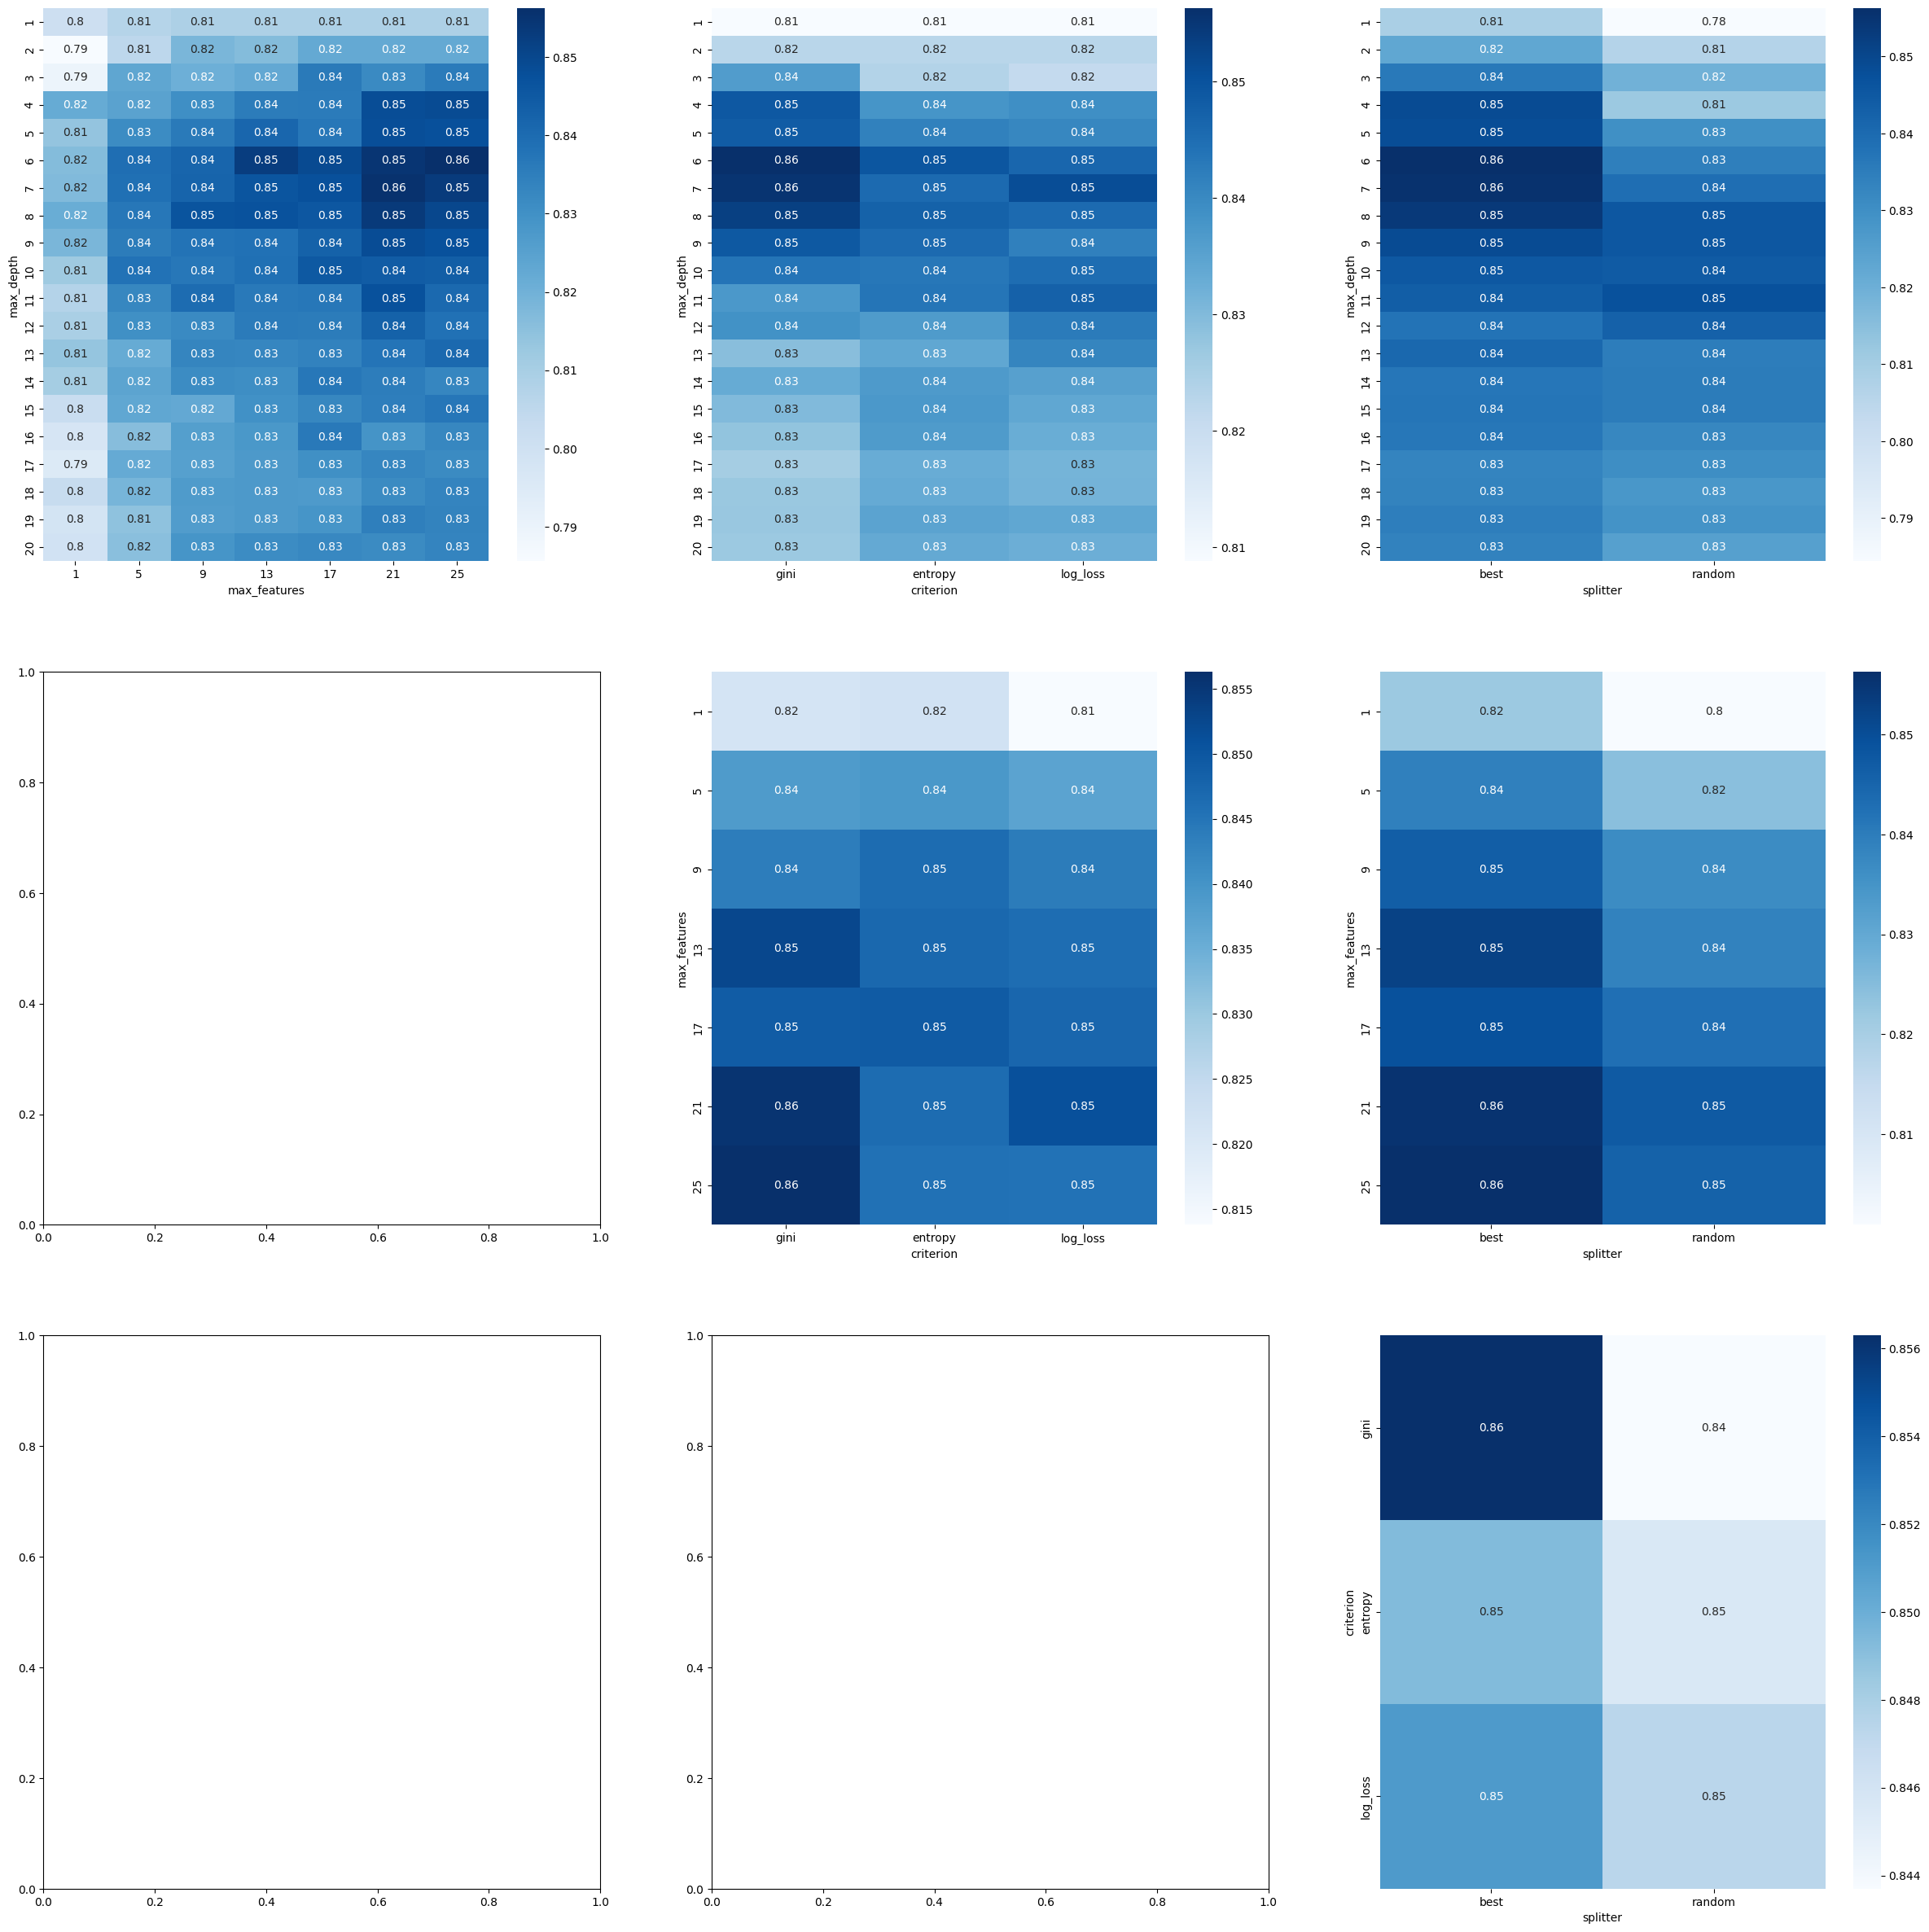

In [371]:
parameter_names_dt = list(parameter_grid_dt.keys())
plot_grid_search(
    grid_search_dt,
    "mean_test_accuracy",
    parameter_grid_dt,
    parameter_names_dt,
    "heatmaps_decision_tree.png",
)

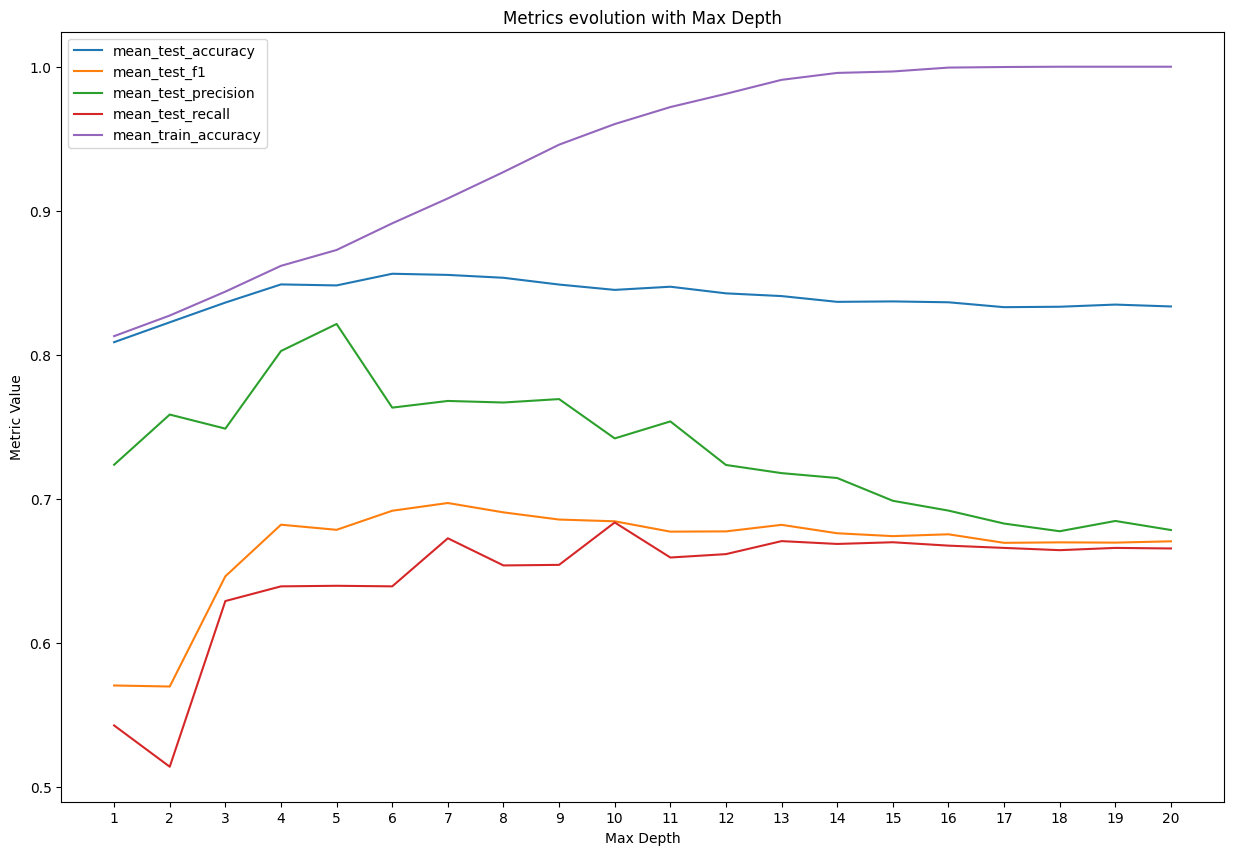

In [372]:
plot_measures(
    "max_depth",
    "Max Depth",
    parameter_grid_dt["max_depth"],
    grid_search_dt.cv_results_,
    [f"mean_test_{metric}" for metric in dt_metrics] + ["mean_train_accuracy"],
    "max_depth_decision_tree.png",
)

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1856
           1       0.89      0.66      0.75       644

    accuracy                           0.89      2500
   macro avg       0.89      0.81      0.84      2500
weighted avg       0.89      0.89      0.88      2500



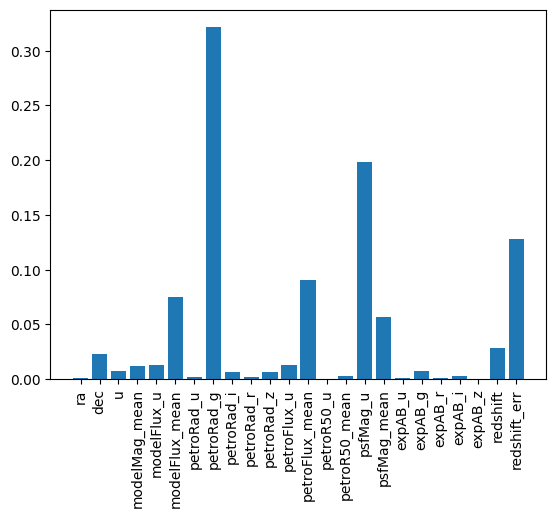

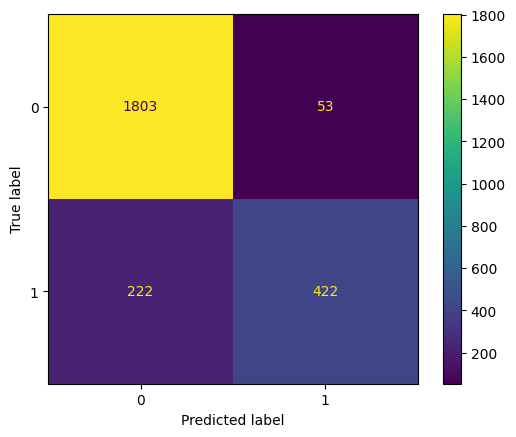

{'accuracy': 0.89,
 'precision': 0.888421052631579,
 'recall': 0.65527950310559,
 'f1': 0.7542448614834674}

In [373]:
print_classification_report(
    grid_search_dt.best_estimator_, testing_inputs, testing_classes
)

## K-NN: Nearest Neighbour

In [374]:
nearest_neighbour = KNeighborsClassifier()

max_leaf_size = 40

knn_metrics = ["accuracy", "f1", "precision", "recall"]
parameter_grid_knn = {
    "n_neighbors": [1, 3, 5, 10, 20, 30, 40, 50],
    "weights": ["uniform", "distance"],
    "algorithm": ["ball_tree", "kd_tree", "brute"],
    # "leaf_size": [1, 5, 10, 25, 50, 100, 200, 500],
}

print(parameter_grid_knn)

grid_search_knn = test_classifier(
    nearest_neighbour, all_inputs_normalized, all_labels, parameter_grid_knn, return_metrics=knn_metrics, optimize_metric="f1", return_train_score=True
)

{'n_neighbors': [1, 3, 5, 10, 20, 30, 40, 50], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute']}
Fitting 2 folds for each of 48 candidates, totalling 96 fits
Best score: 0.625014127088015
Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1845
           1       1.00      1.00      1.00       655

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500



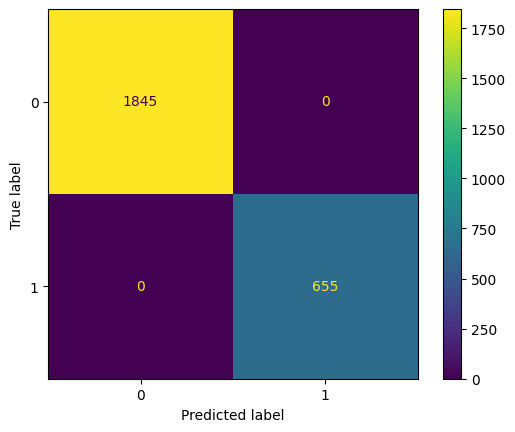

{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}

In [375]:
print_classification_report(
    grid_search_knn.best_estimator_,
    testing_inputs_normalized,
    testing_classes_normalized,
    False,
)

Best score: 0.625014127088015
Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}


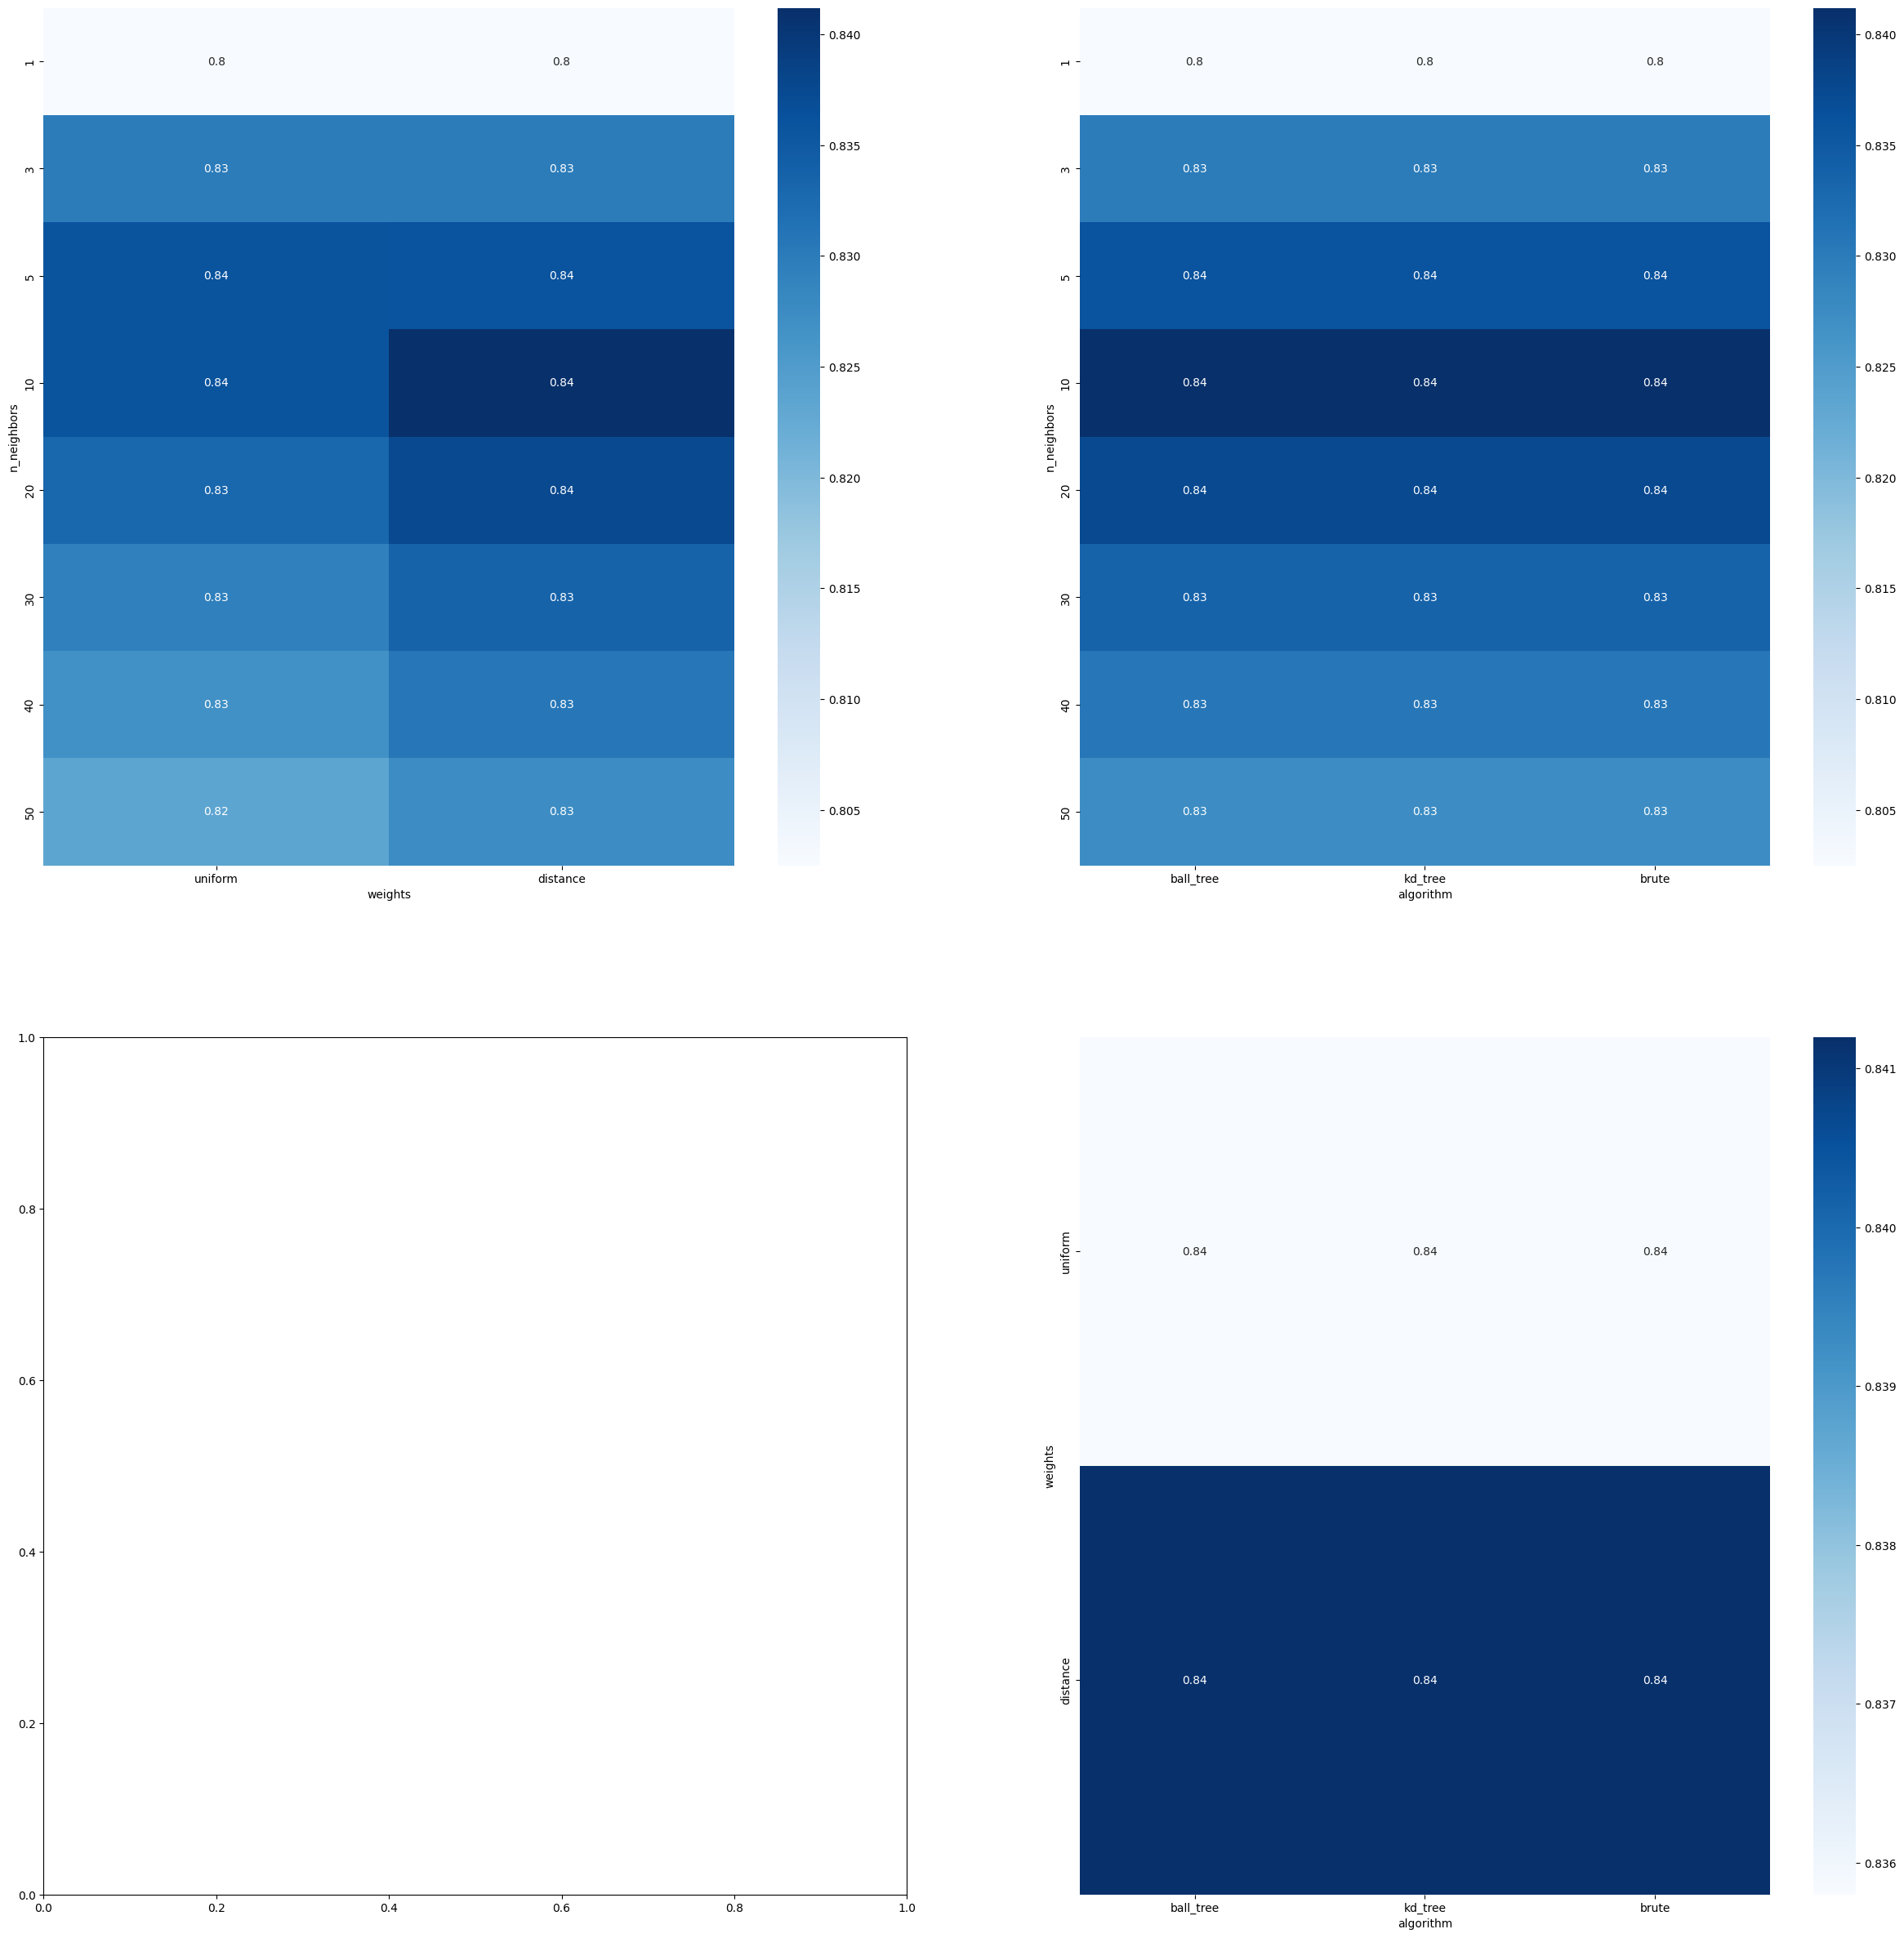

In [376]:
parameter_names_knn = list(parameter_grid_knn.keys())
plot_grid_search(
    grid_search_knn,
    "mean_test_accuracy",
    parameter_grid_knn,
    parameter_names_knn,
    "heatmaps_knn",
)

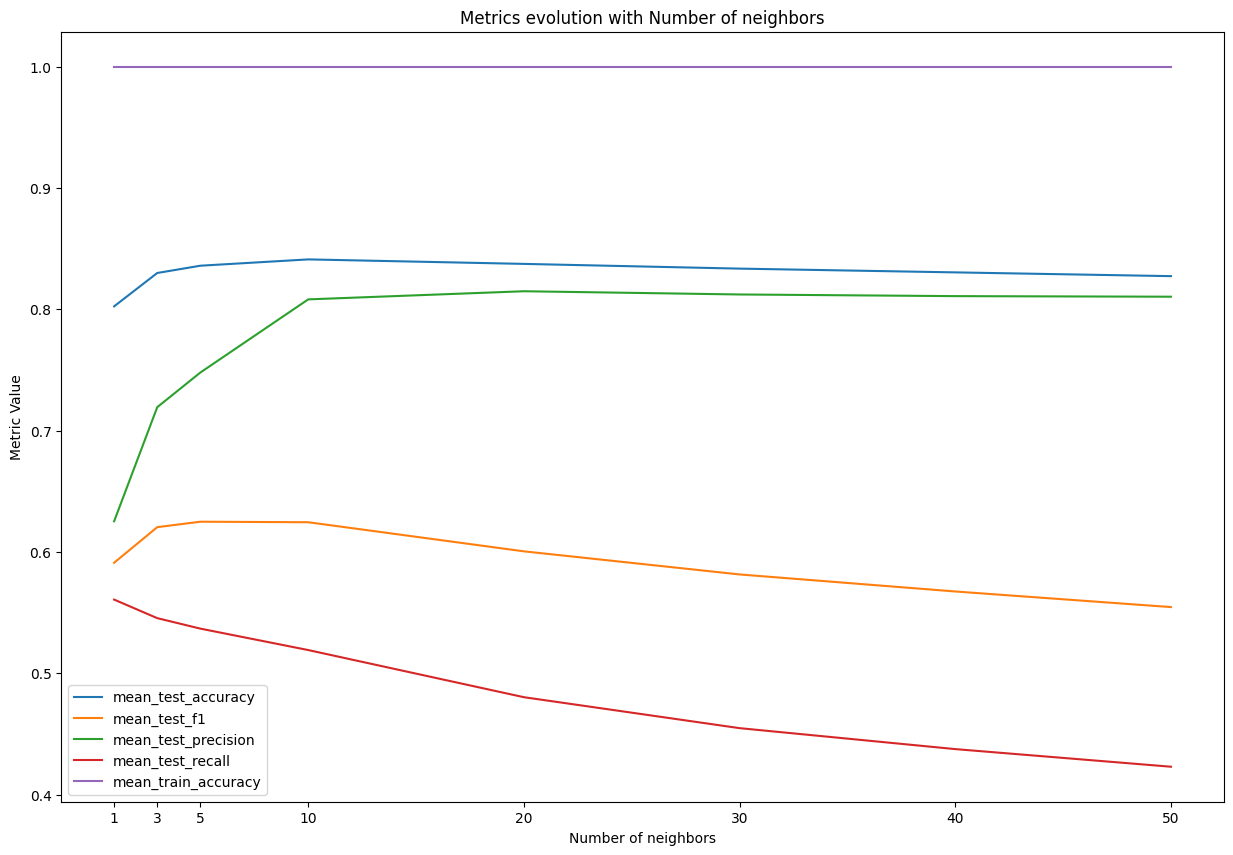

In [377]:
plot_measures(
    "n_neighbors",
    "Number of neighbors",
    parameter_grid_knn["n_neighbors"],
    grid_search_knn.cv_results_,
    [f"mean_test_{metric}" for metric in knn_metrics] + ["mean_train_accuracy"],
    "metrics_vs_neighbors.png",
)

## SVM: Support Vector Machine

In [378]:
C_list = [0.1, 0.5, 1, 3, 5]
gamma_list = ["scale", "auto"]
coef0_list = [-2, 0, 2]
shrinking_list = [True, False]
class_weight = ["balanced", None]

### SVM Linear

In [379]:
svm_linear = SVC()

parameter_grid_linear = {
    "C": C_list,
    "kernel": ["linear"],
    "shrinking": shrinking_list,
    "class_weight": class_weight,
}

print(parameter_grid_linear)

grid_search_linear = test_classifier(
    svm_linear,
    inputs_under_sampl_normalized,
    labels_under_sampl_normalized,
    parameter_grid_linear,
)

{'C': [0.1, 0.5, 1, 3, 5], 'kernel': ['linear'], 'shrinking': [True, False], 'class_weight': ['balanced', None]}
Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best score: 0.8437990580847724
Best parameters: {'C': 0.5, 'class_weight': 'balanced', 'kernel': 'linear', 'shrinking': True}


              precision    recall  f1-score   support

           0       0.96      0.85      0.90      1845
           1       0.69      0.90      0.78       655

    accuracy                           0.87      2500
   macro avg       0.82      0.88      0.84      2500
weighted avg       0.89      0.87      0.87      2500



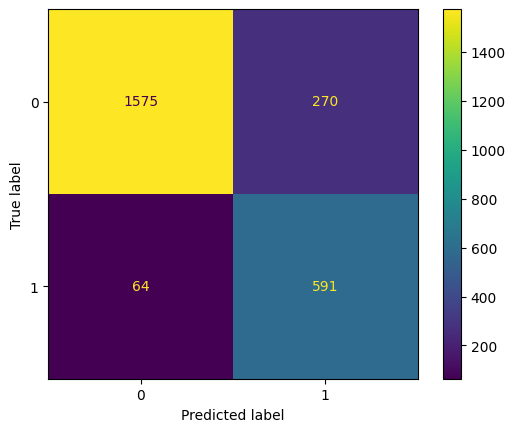

In [380]:
clf_report_linear = print_classification_report(
    grid_search_linear.best_estimator_,
    testing_inputs_normalized,
    testing_classes_normalized,
    False,
)

Best score: 0.8437990580847724
Best parameters: {'C': 0.5, 'class_weight': 'balanced', 'kernel': 'linear', 'shrinking': True}


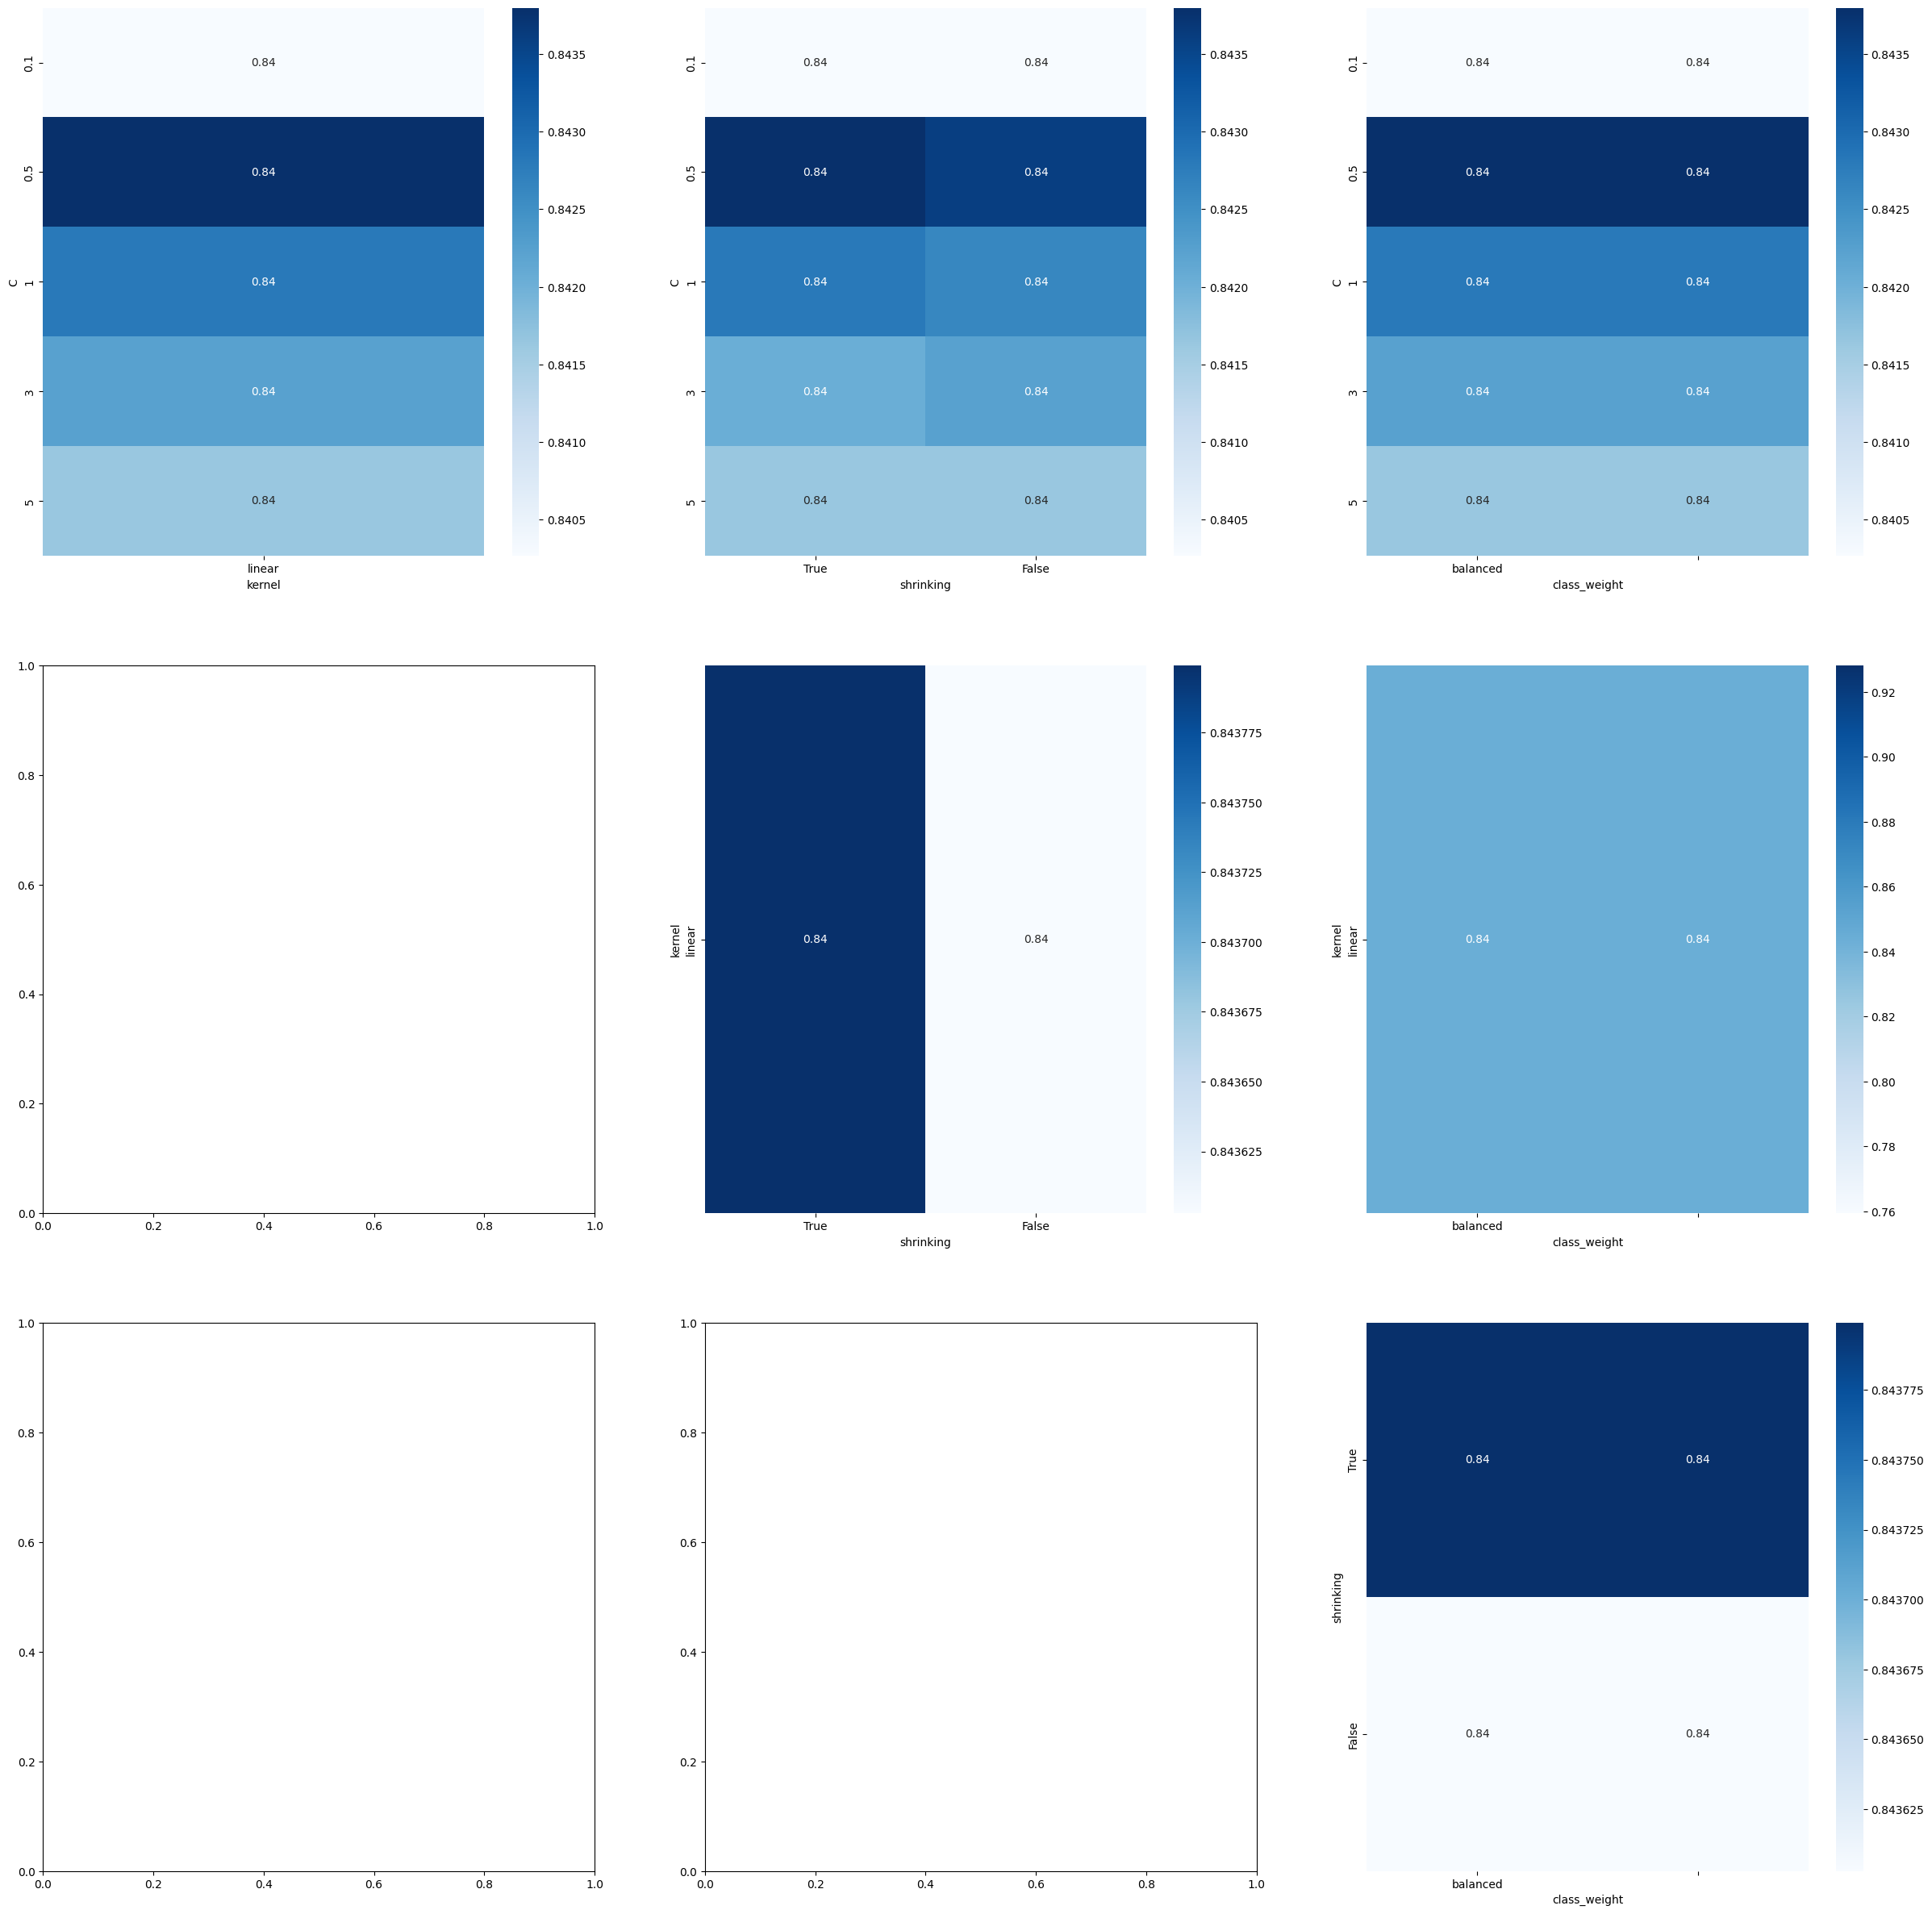

In [381]:
parameter_names_linear = list(parameter_grid_linear.keys())
plot_grid_search(
    grid_search_linear,
    "mean_test_score",
    parameter_grid_linear,
    parameter_names_linear,
    "heatmaps_svm_linear",
)

### SVM Polynomial

In [382]:
svm_poly = SVC()

parameter_grid_poly = {
    "C": C_list,
    "kernel": ["poly"],
    "degree": list(range(1, 6, 2)),
    "gamma": gamma_list,
    "coef0": coef0_list,
    "shrinking": shrinking_list,
    "class_weight": class_weight,
}

print(parameter_grid_poly)

grid_search_poly = test_classifier(
    svm_poly,
    inputs_under_sampl_normalized,
    labels_under_sampl_normalized,
    parameter_grid_poly,
)

{'C': [0.1, 0.5, 1, 3, 5], 'kernel': ['poly'], 'degree': [1, 3, 5], 'gamma': ['scale', 'auto'], 'coef0': [-2, 0, 2], 'shrinking': [True, False], 'class_weight': ['balanced', None]}
Fitting 2 folds for each of 360 candidates, totalling 720 fits
Best score: 0.842032967032967
Best parameters: {'C': 0.5, 'class_weight': 'balanced', 'coef0': 2, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'shrinking': True}


              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1845
           1       0.71      0.92      0.80       655

    accuracy                           0.88      2500
   macro avg       0.84      0.89      0.86      2500
weighted avg       0.90      0.88      0.88      2500



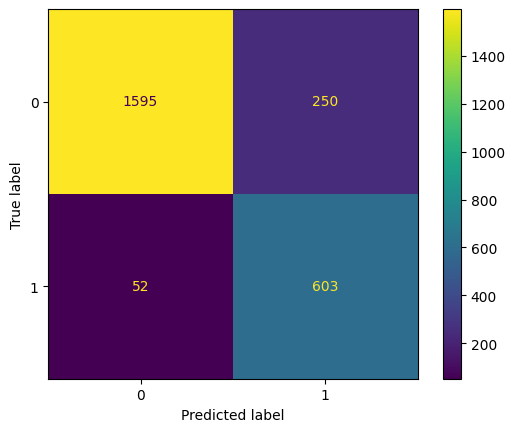

In [383]:
clf_poly_report = print_classification_report(
    grid_search_poly.best_estimator_,
    testing_inputs_normalized,
    testing_classes_normalized,
    False,
)

Best score: 0.842032967032967
Best parameters: {'C': 0.5, 'class_weight': 'balanced', 'coef0': 2, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'shrinking': True}


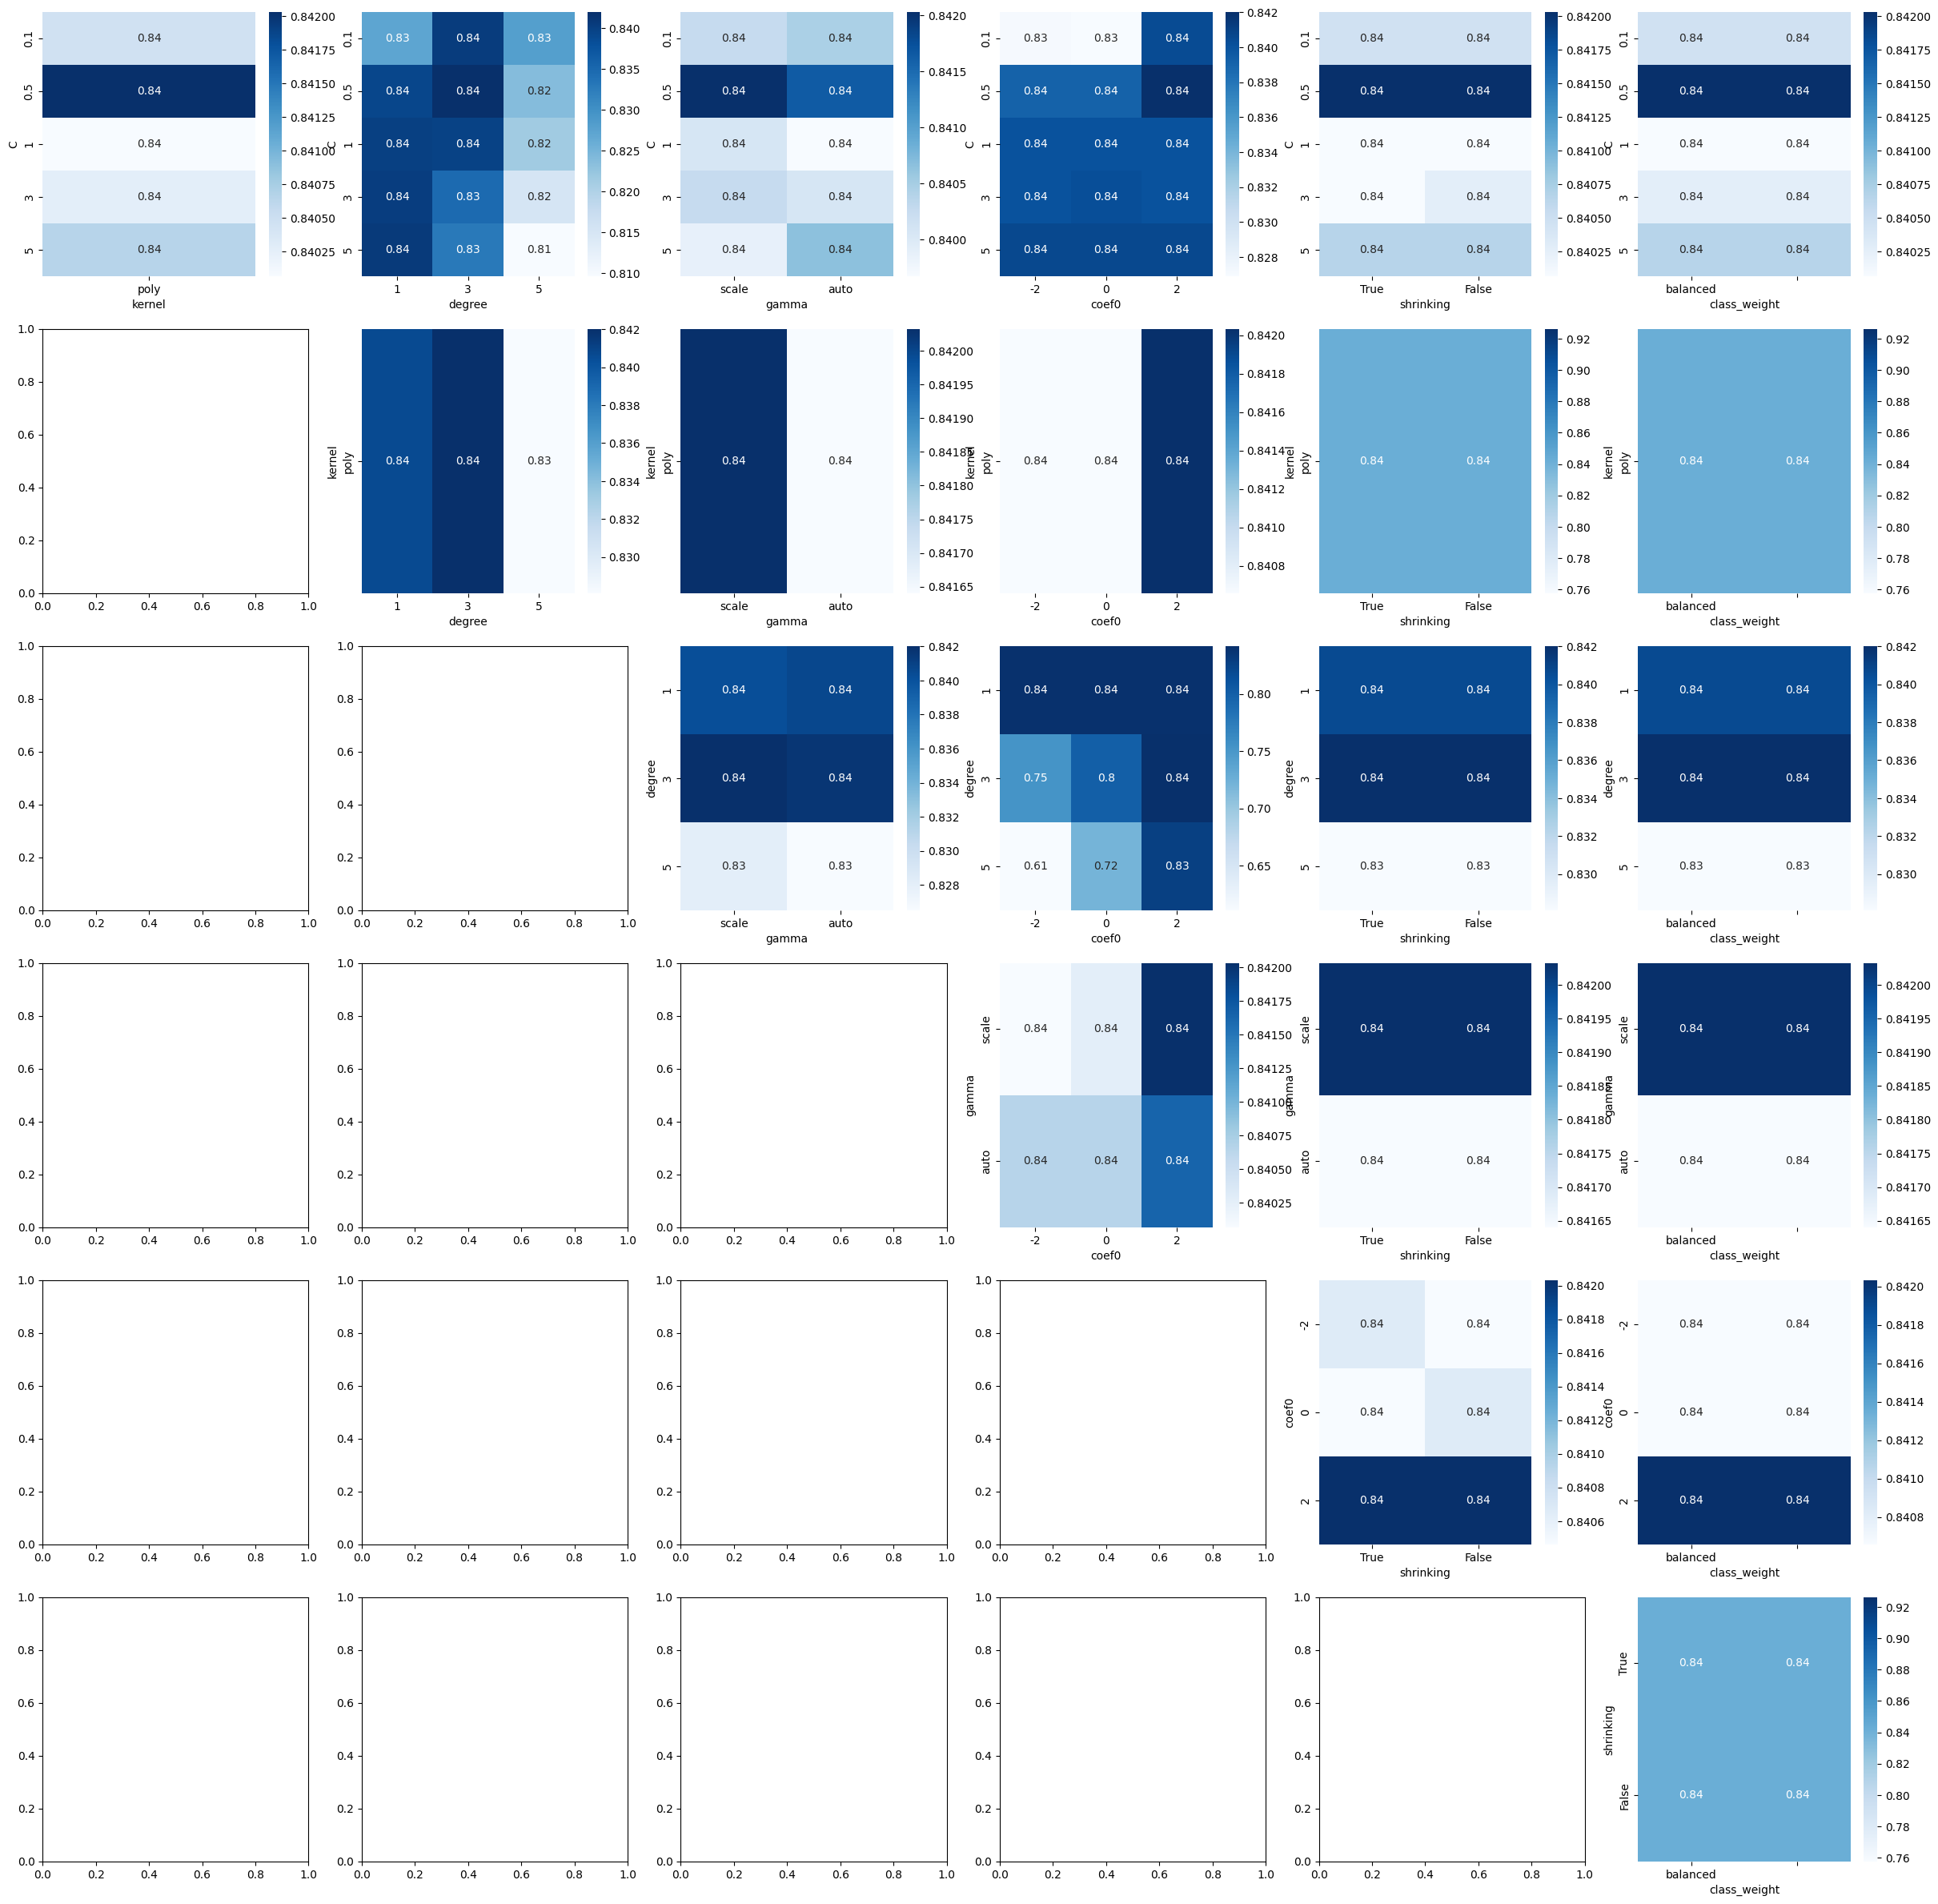

In [384]:
parameter_names_poly = list(parameter_grid_poly.keys())
plot_grid_search(
    grid_search_poly, "mean_test_score", parameter_grid_poly, parameter_names_poly, "heatmaps_svm_poly"
)

### SVM Radial Basis Function

In [385]:
svm_rbf = SVC()

parameter_grid_rbf = {
    "C": C_list,
    "kernel": ["rbf"],
    "gamma": gamma_list,
    "shrinking": shrinking_list,
    "class_weight": class_weight,
}

print(parameter_grid_rbf)

grid_search_rbf = test_classifier(
    svm_rbf,
    inputs_under_sampl_normalized,
    labels_under_sampl_normalized,
    parameter_grid_rbf,
)

{'C': [0.1, 0.5, 1, 3, 5], 'kernel': ['rbf'], 'gamma': ['scale', 'auto'], 'shrinking': [True, False], 'class_weight': ['balanced', None]}
Fitting 2 folds for each of 40 candidates, totalling 80 fits
Best score: 0.8412480376766092
Best parameters: {'C': 3, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}


Best score: 0.8412480376766092
Best parameters: {'C': 3, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}


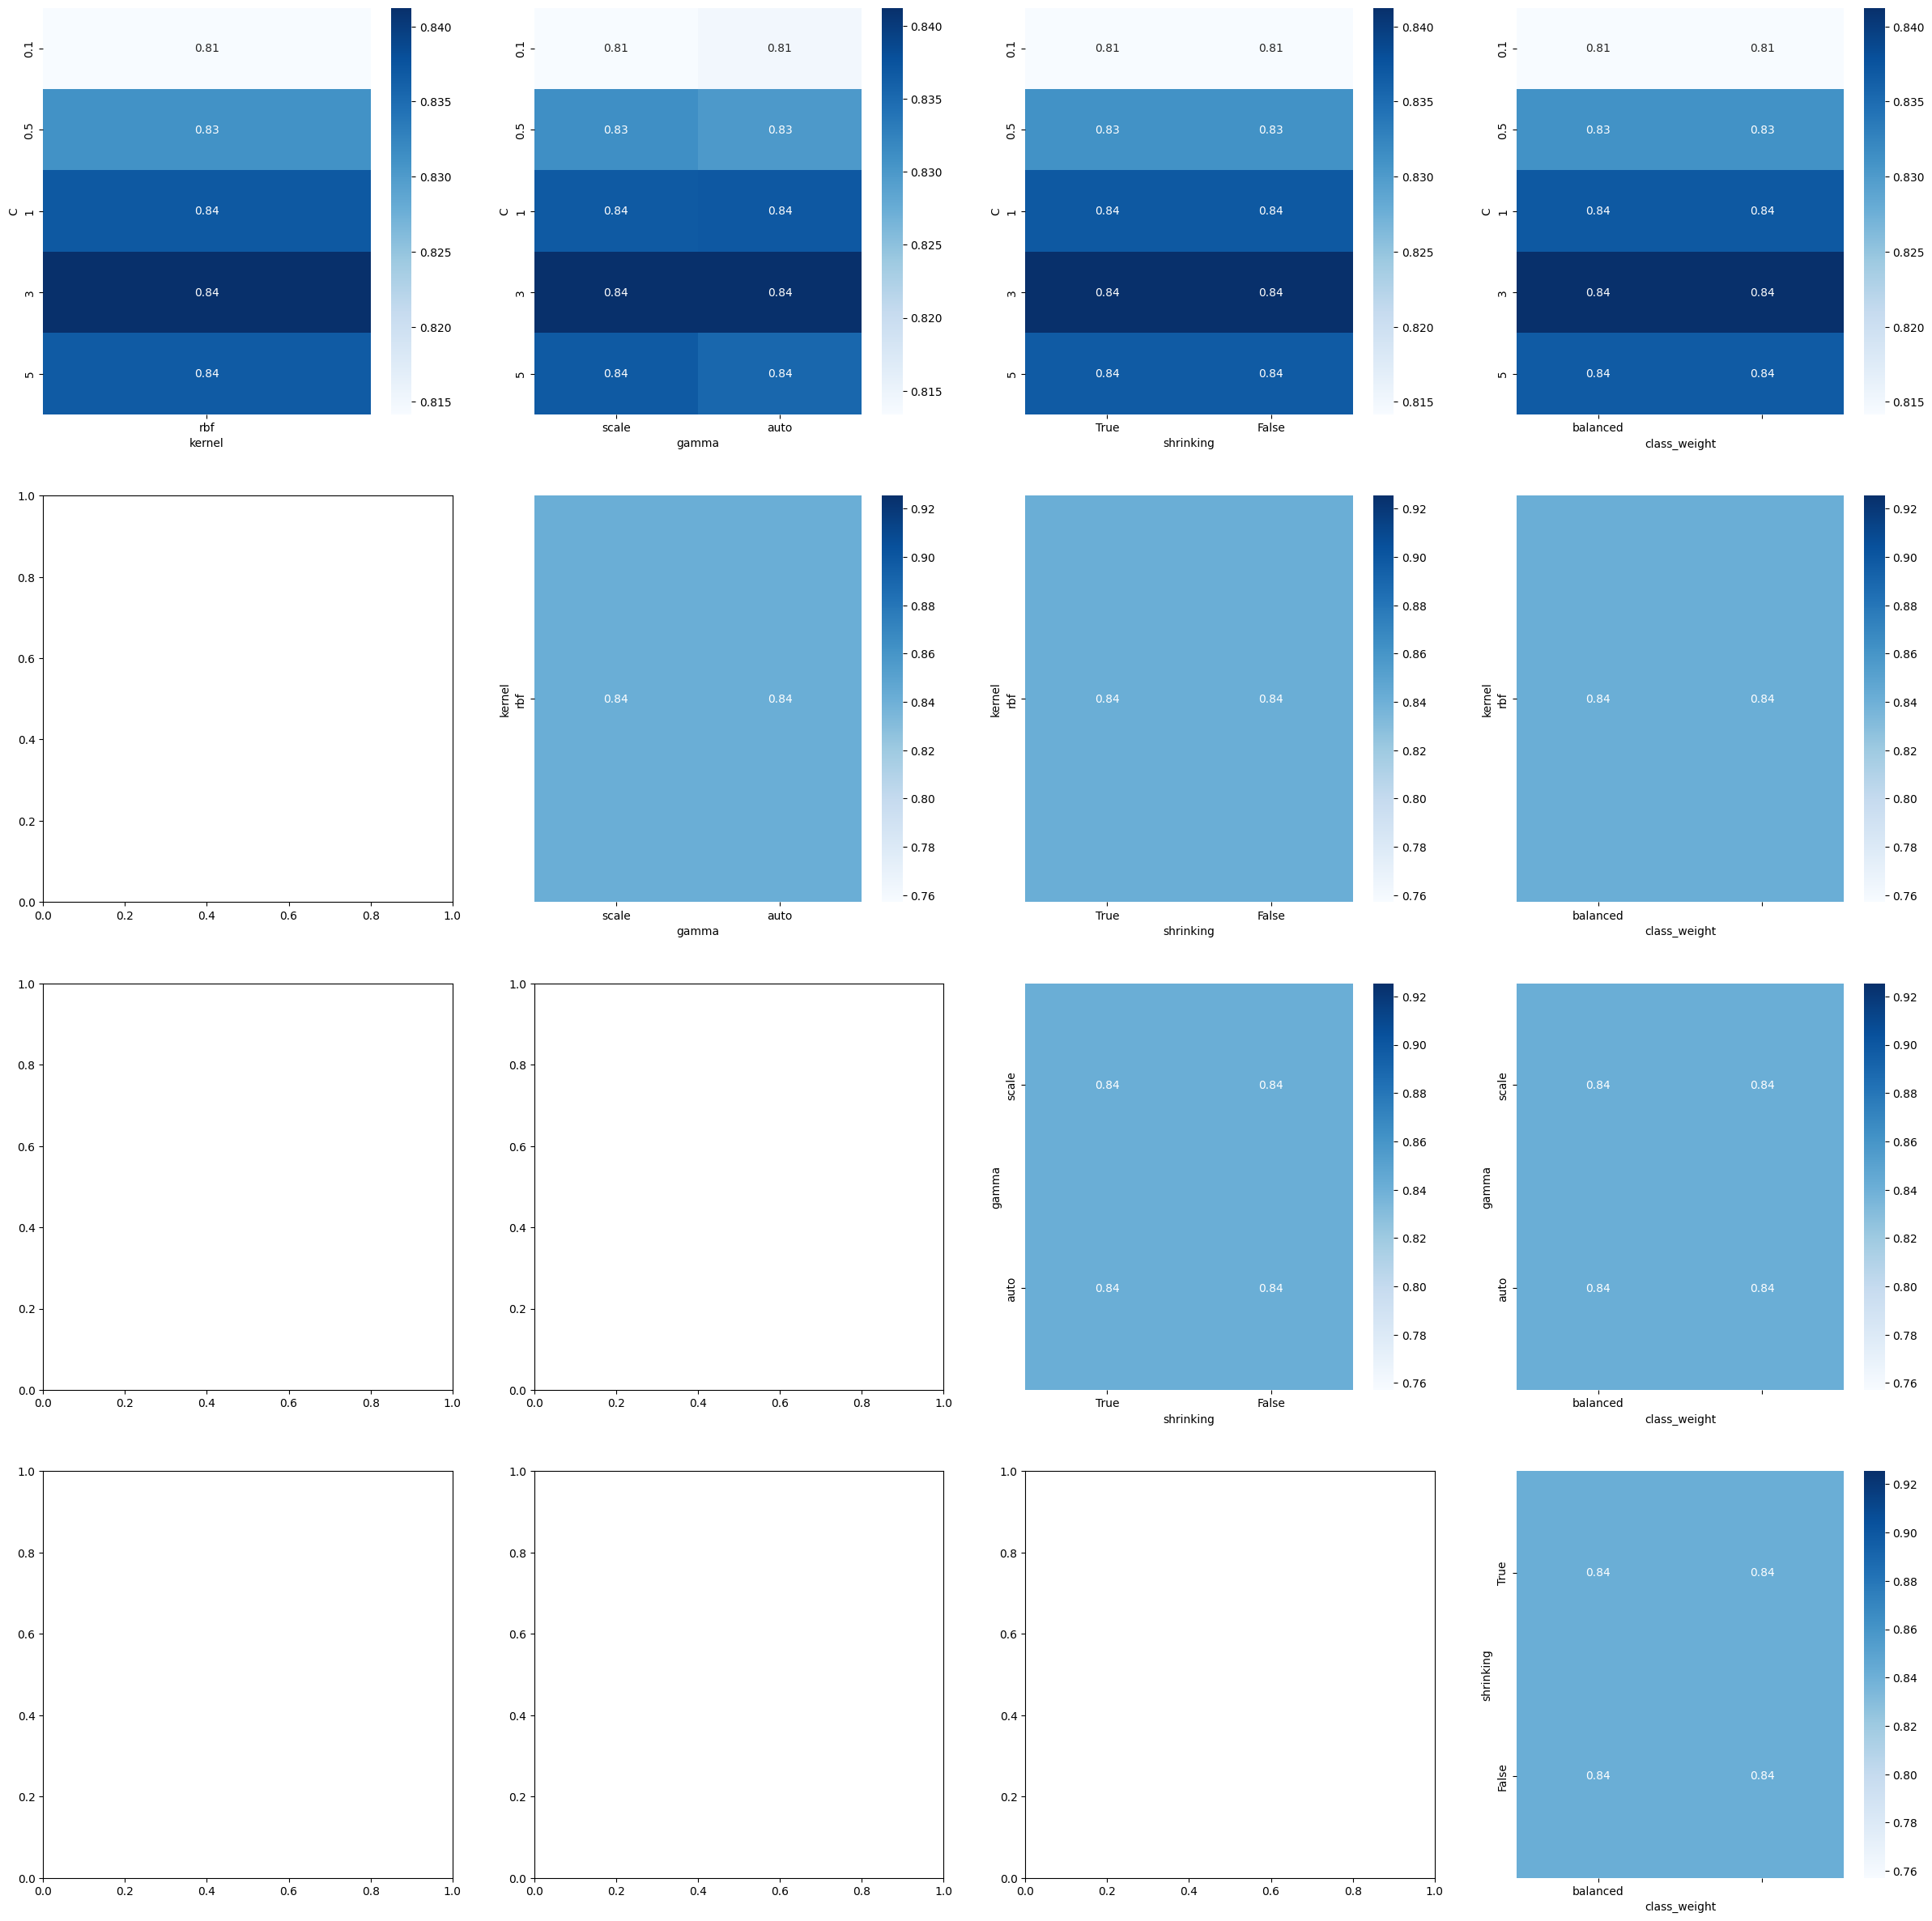

In [386]:
parameter_names_rbf = list(parameter_grid_rbf.keys())
plot_grid_search(
    grid_search_rbf, "mean_test_score", parameter_grid_rbf, parameter_names_rbf, "heatmaps_svm_rbf"
)

              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1845
           1       0.70      0.93      0.80       655

    accuracy                           0.88      2500
   macro avg       0.84      0.89      0.86      2500
weighted avg       0.90      0.88      0.88      2500



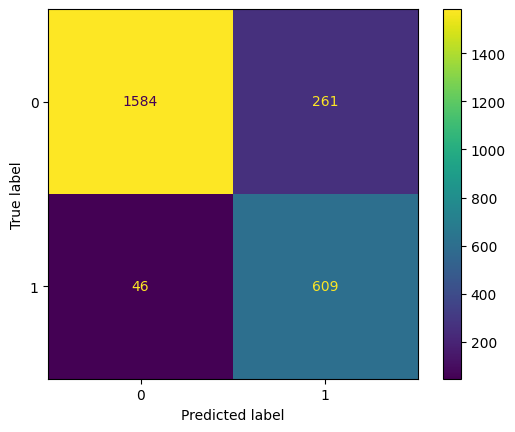

In [387]:
clf_rbf_report = print_classification_report(
    grid_search_rbf.best_estimator_,
    testing_inputs_normalized,
    testing_classes_normalized,
    False,
)

### SVM Sigmoid

In [388]:
svm_sigmoid = SVC()

parameter_grid_sigmoid = {
    "C": C_list,
    "kernel": ["sigmoid"],
    "gamma": gamma_list,
    "coef0": coef0_list,
    "shrinking": shrinking_list,
    "class_weight": class_weight,
}

print(parameter_grid_sigmoid)

grid_search_sigmoid = test_classifier(
    svm_sigmoid,
    inputs_under_sampl_normalized,
    labels_under_sampl_normalized,
    parameter_grid_sigmoid,
)

{'C': [0.1, 0.5, 1, 3, 5], 'kernel': ['sigmoid'], 'gamma': ['scale', 'auto'], 'coef0': [-2, 0, 2], 'shrinking': [True, False], 'class_weight': ['balanced', None]}
Fitting 2 folds for each of 120 candidates, totalling 240 fits
Best score: 0.7868916797488226
Best parameters: {'C': 1, 'class_weight': 'balanced', 'coef0': -2, 'gamma': 'scale', 'kernel': 'sigmoid', 'shrinking': True}


              precision    recall  f1-score   support

           0       0.92      0.78      0.85      1845
           1       0.57      0.81      0.67       655

    accuracy                           0.79      2500
   macro avg       0.75      0.80      0.76      2500
weighted avg       0.83      0.79      0.80      2500



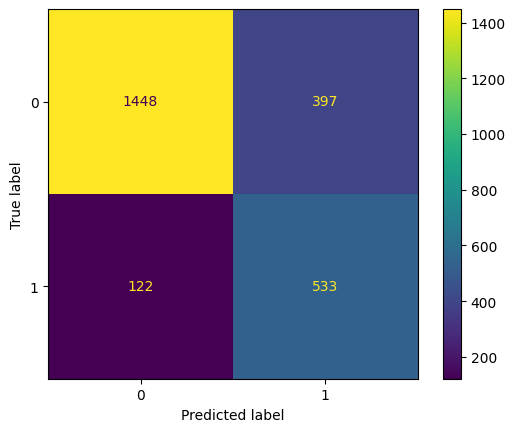

In [389]:
clf_sigmoid_report = print_classification_report(
    grid_search_sigmoid.best_estimator_,
    testing_inputs_normalized,
    testing_classes_normalized,
    False,
)

Best score: 0.7868916797488226
Best parameters: {'C': 1, 'class_weight': 'balanced', 'coef0': -2, 'gamma': 'scale', 'kernel': 'sigmoid', 'shrinking': True}


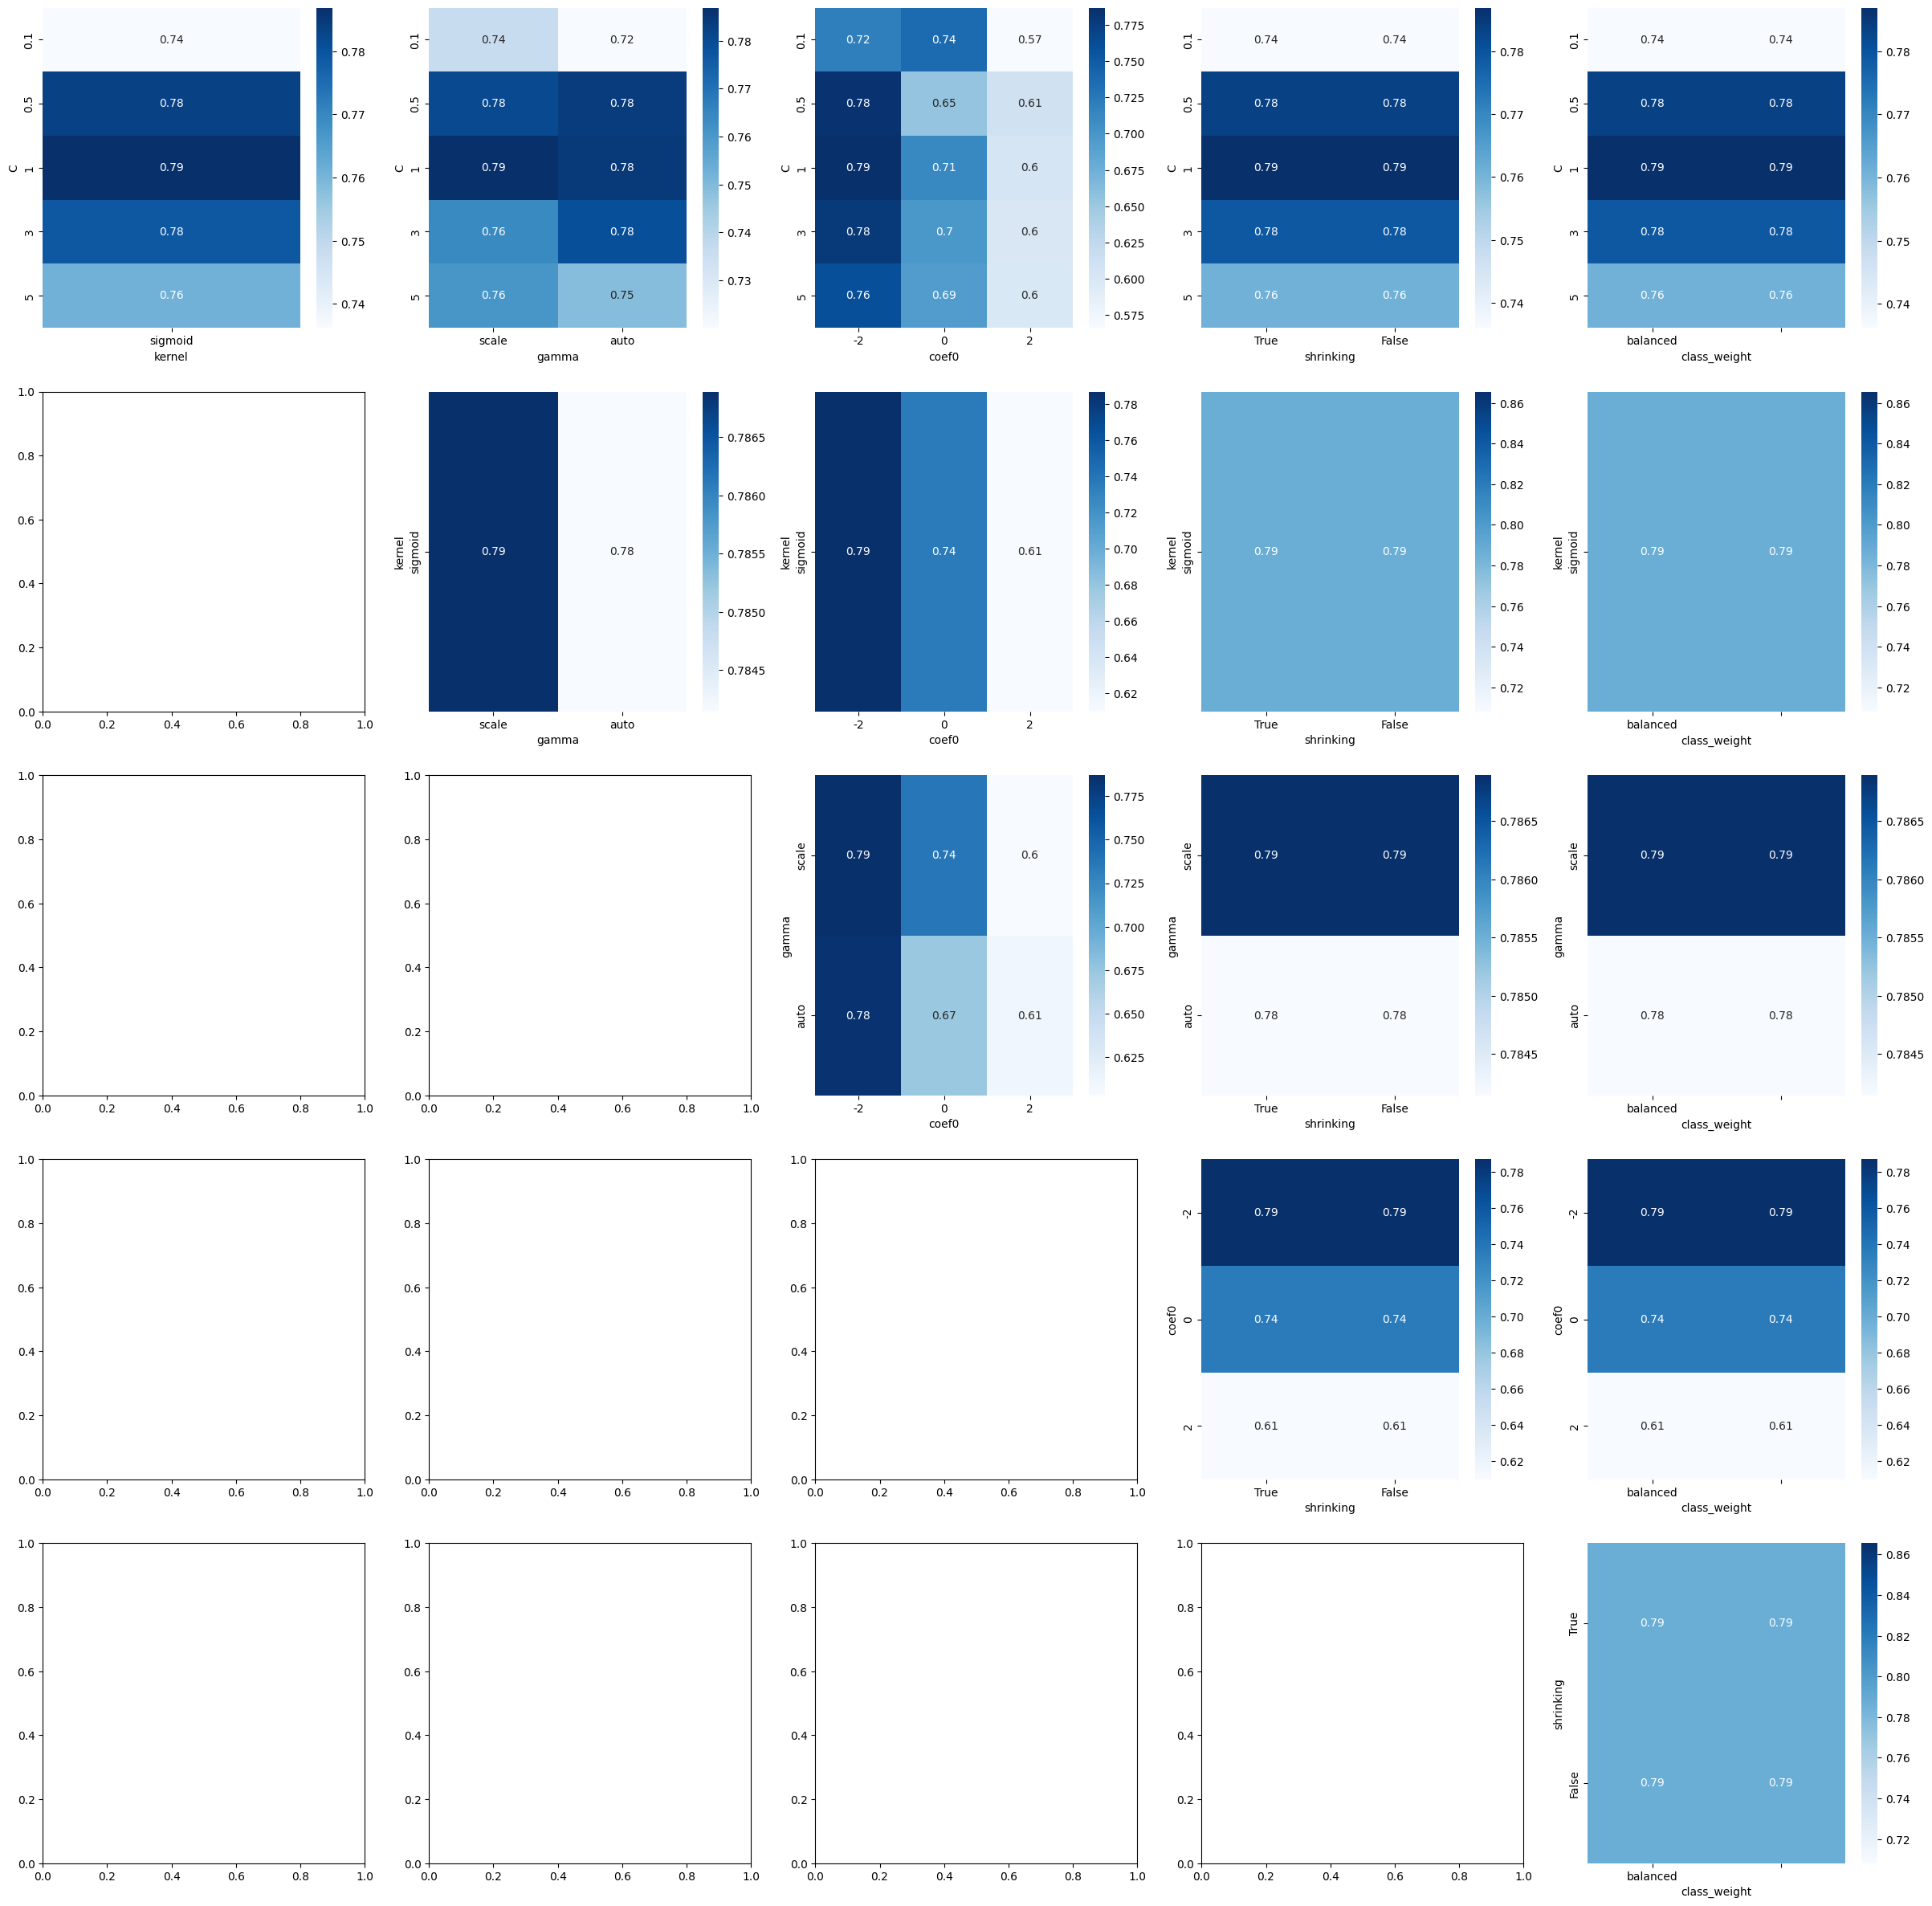

In [390]:
parameter_names_sigmoid = list(parameter_grid_sigmoid.keys())
plot_grid_search(
    grid_search_sigmoid,
    "mean_test_score",
    parameter_grid_sigmoid,
    parameter_names_sigmoid,
    "heatmaps_svm_sigmoid",
)

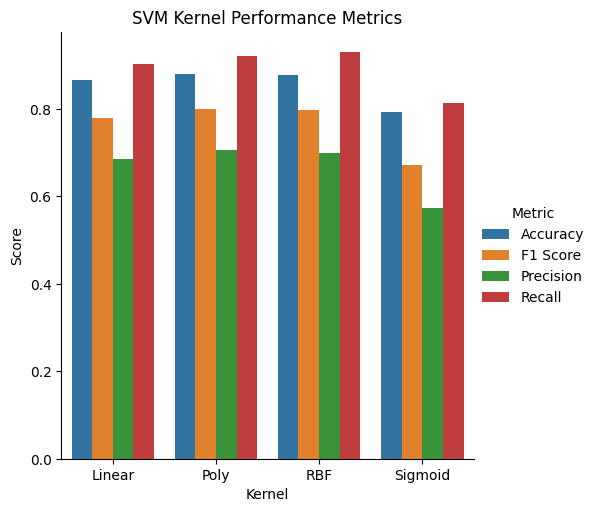

In [391]:
def plot_svms():
    reports = clf_report_linear, clf_poly_report, clf_rbf_report, clf_sigmoid_report
    kernel_names = ["Linear", "Poly", "RBF", "Sigmoid"]

    data = []
    for kernel, report in zip(kernel_names, reports):
        data.append({
            "Kernel": kernel,
            "Metric": "Accuracy",
            "Score": report["accuracy"]
        })
        data.append({
            "Kernel": kernel,
            "Metric": "F1 Score",
            "Score": report["f1"]
        })
        data.append({
            "Kernel": kernel,
            "Metric": "Precision",
            "Score": report["precision"]
        })
        data.append({
            "Kernel": kernel,
            "Metric": "Recall",
            "Score": report["recall"]
        })

    data = pd.DataFrame(data)

    sb.catplot(x="Kernel", y="Score", hue="Metric", data=data, kind="bar", dodge=True, errorbar=None)
    plt.title('SVM Kernel Performance Metrics')
    plt.ylabel('Score')
    plt.xlabel('Kernel')
    plt.savefig("svms_metrics.png", bbox_inches="tight")

plot_svms()

## Redes Neuronais

In [392]:
neural_networks = MLPClassifier()

parameter_grid_neural_networks = {
    "activation": ["identity", "logistic", "tanh", "relu"],
    "solver": ["lbfgs", "sgd", "adam"],
    "hidden_layer_sizes": [(100,), (50, 50, 50), (10, 10, 10, 10, 10)],
    "alpha": [0.0001, 0.05, 1],
    "learning_rate": ["constant", "invscaling", "adaptive"],
    "max_iter": [10, 50, 100, 200, 400],
}

print(parameter_grid_neural_networks)
nn_metrics = ["accuracy", "f1", "precision", "recall"]

grid_search_neural_networks = test_classifier(
    neural_networks,
    inputs_under_sampl_normalized,
    labels_under_sampl_normalized,
    parameter_grid_neural_networks,
    return_metrics=nn_metrics,
    optimize_metric="f1",
    return_train_score=True
)

{'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'], 'hidden_layer_sizes': [(100,), (50, 50, 50), (10, 10, 10, 10, 10)], 'alpha': [0.0001, 0.05, 1], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'max_iter': [10, 50, 100, 200, 400]}
Fitting 2 folds for each of 1620 candidates, totalling 3240 fits
Best score: 0.8573714049532816
Best parameters: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'max_iter': 50, 'solver': 'lbfgs'}


C:\Users\Clara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


              precision    recall  f1-score   support

           0       0.97      0.87      0.92      1845
           1       0.71      0.91      0.80       655

    accuracy                           0.88      2500
   macro avg       0.84      0.89      0.86      2500
weighted avg       0.90      0.88      0.89      2500



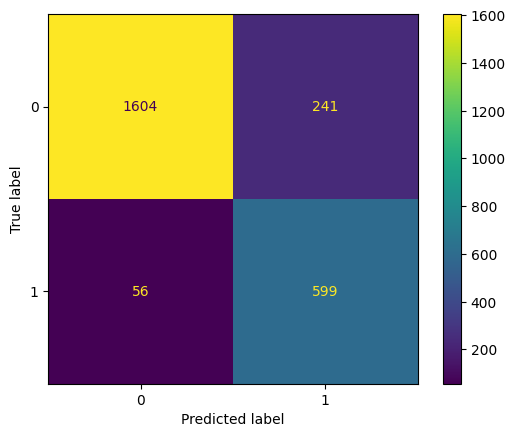

{'accuracy': 0.8812,
 'precision': 0.7130952380952381,
 'recall': 0.9145038167938931,
 'f1': 0.8013377926421404}

In [393]:
print_classification_report(
    grid_search_neural_networks.best_estimator_,
    testing_inputs_normalized,
    testing_classes_normalized,
    False,
)

Best score: 0.8573714049532816
Best parameters: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'max_iter': 50, 'solver': 'lbfgs'}


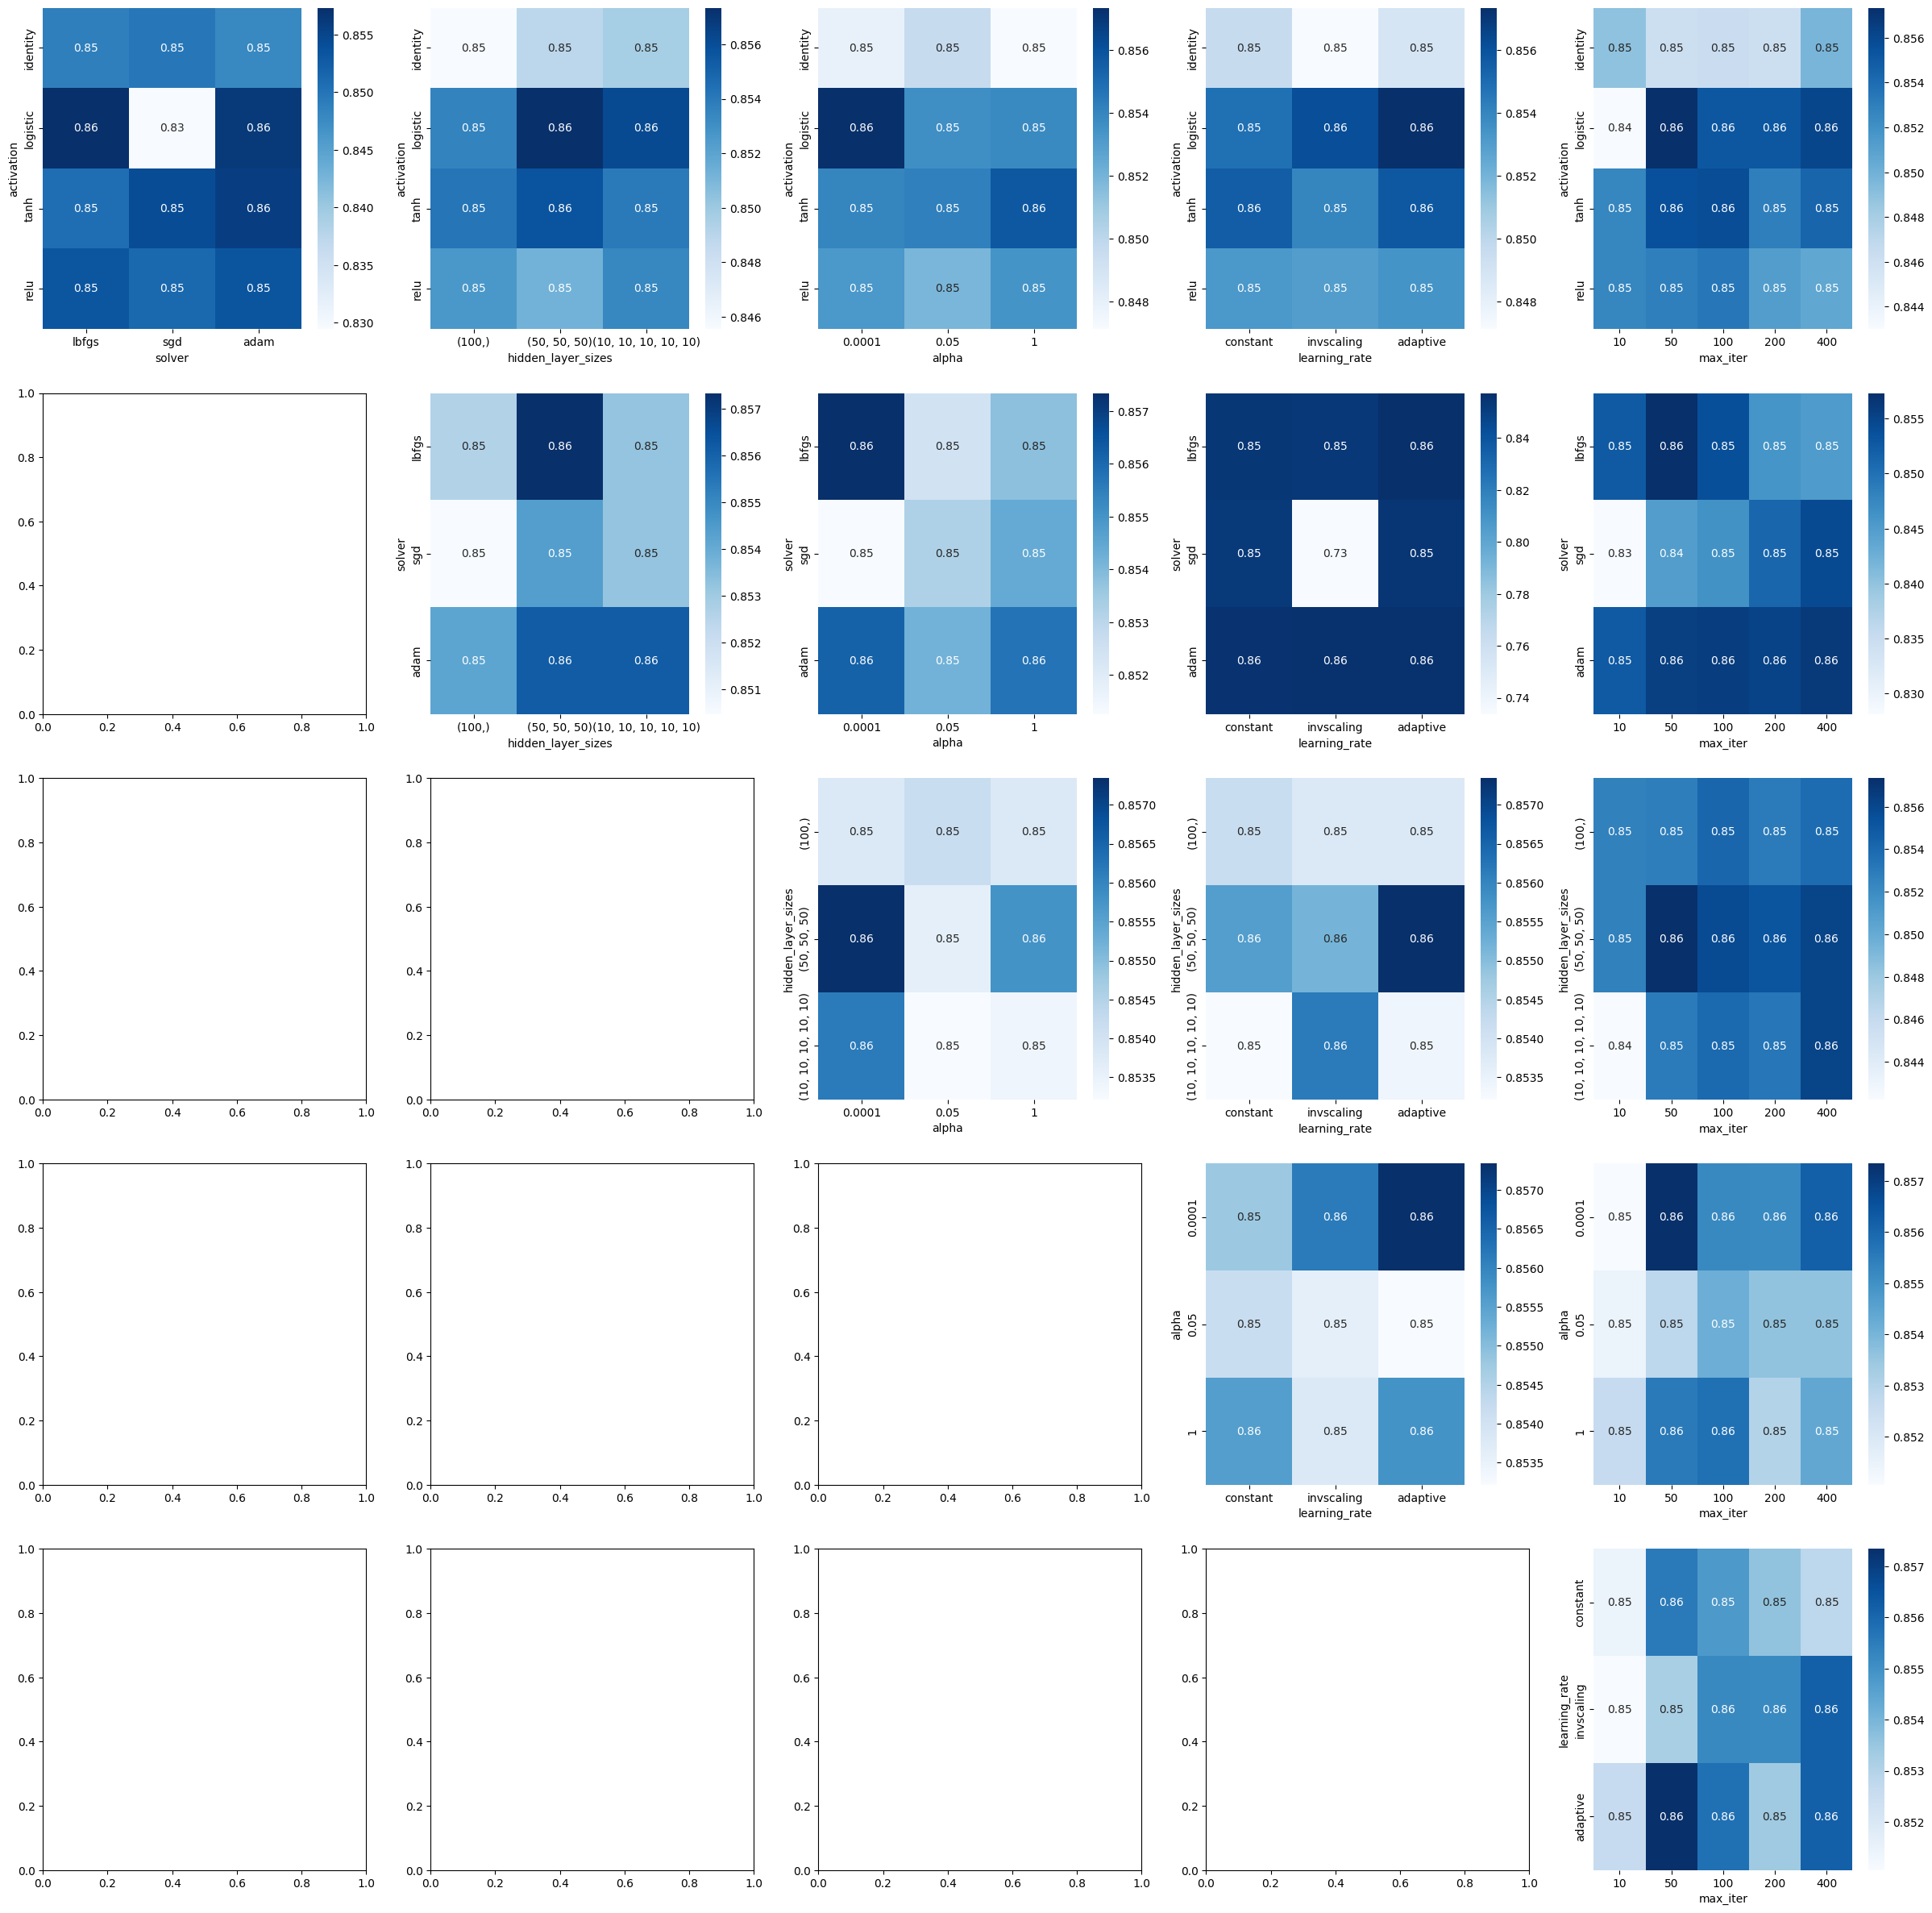

In [394]:
parameter_names_neural_networks = list(parameter_grid_neural_networks.keys())
plot_grid_search(
    grid_search_neural_networks,
    "mean_test_accuracy",
    parameter_grid_neural_networks,
    parameter_names_neural_networks,
    "heatmaps_neural_networks.png"
)

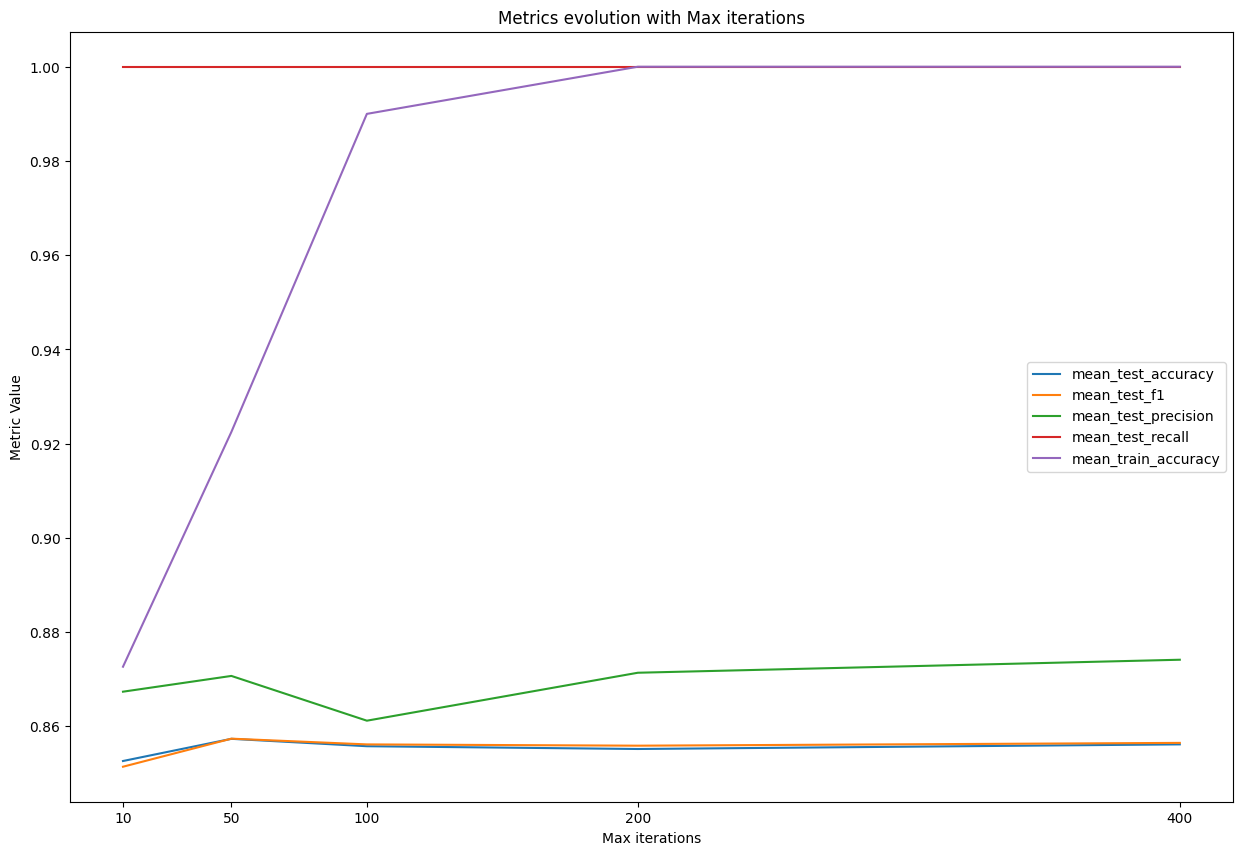

In [395]:
plot_measures(
    "max_iter",
    "Max iterations",
    parameter_grid_neural_networks["max_iter"],
    grid_search_neural_networks.cv_results_,
    [f"mean_test_{metric}" for metric in nn_metrics] + ["mean_train_accuracy"],
    "metrics_vs_max_iter.png",
)